In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


In [189]:
def calcular_metricas(y_true, y_pred):
    """Calcula MAPE, MAE y RMSE entre valores reales y predicciones"""
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    # Convertir a numpy arrays si es necesario
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filtrar valores donde y_true no sea 0 para MAPE
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # MAPE (Mean Absolute Percentage Error)
    if len(y_true_filtered) > 0:
        mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    else:
        mape = np.inf
    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE (Root Mean Square Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return mape, mae, rmse

# Lista para almacenar resultados de todas las métricas
resultados_metricas = []

# Importacion Gasolina Regular

In [190]:
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

ts_imp_reg.head()

Fecha
2001-01-01    177776.50
2001-01-02    123115.99
2001-01-03    161726.42
2001-01-04    127338.74
2001-01-05    168730.19
Name: Gasolina regular, dtype: float64

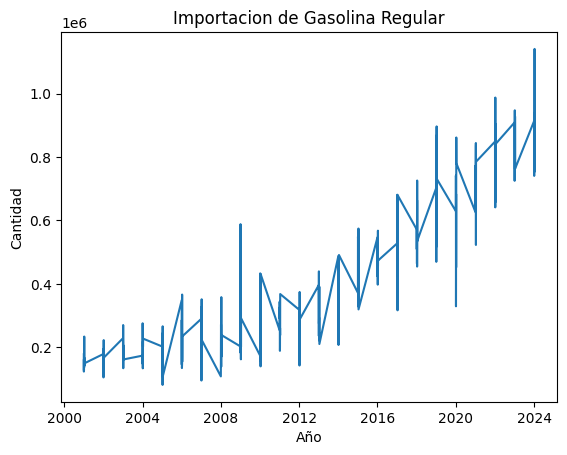

In [191]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

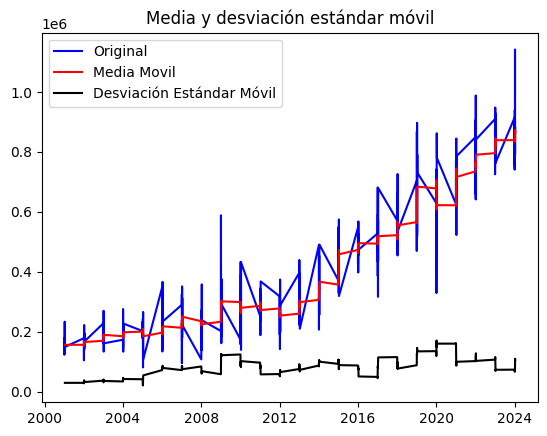

In [192]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

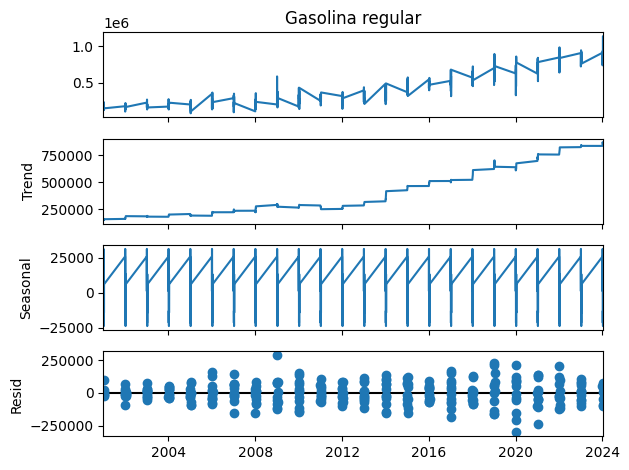

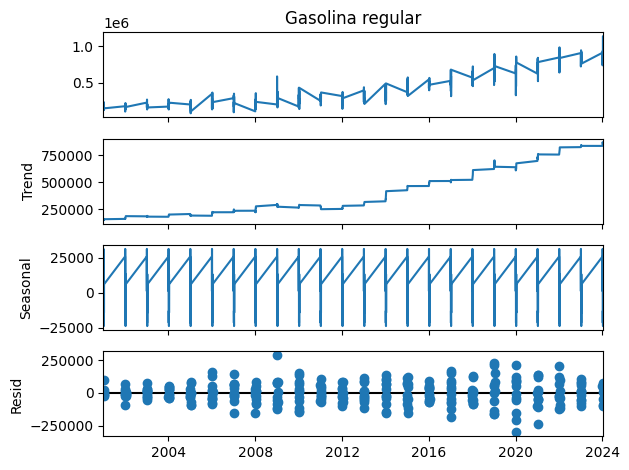

In [193]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [194]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.830167
p-value                        0.992108
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


In [195]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.023316e+01
p-value                      4.967668e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.790000e+02
Critical Value (1%)         -3.454008e+00
Critical Value (5%)         -2.871956e+00
Critical Value (10%)        -2.572320e+00
dtype: float64


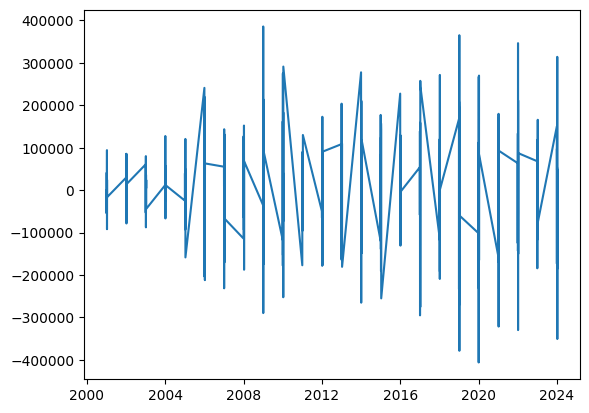

In [196]:
plt.plot(ts_imp_reg_diff)

In [197]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2001-01-02   -0.418384
2001-01-03    0.265049
2001-01-04   -0.269837
2001-01-05    0.285427
2001-01-06   -0.133866
2001-01-07   -0.139499
Name: diff_scaled, dtype: float64

## Entrenamiento

In [198]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [199]:
train, type(train)

(array([[-0.01786488],
        [-0.41838396],
        [ 0.26504895],
        [-0.26983695],
        [ 0.28542658],
        [-0.13386558],
        [-0.13949932],
        [ 0.00460047],
        [ 0.67295214],
        [-0.69267044],
        [ 0.1601266 ],
        [-0.13967393],
        [ 0.19732793],
        [-0.26801243],
        [-0.30930178],
        [ 0.60983895],
        [ 0.01504318],
        [-0.44123656],
        [ 0.60758094],
        [-0.59389328],
        [ 0.07857755],
        [ 0.26401923],
        [-0.32738205],
        [ 0.08773027],
        [ 0.42670855],
        [-0.11882757],
        [-0.40792564],
        [ 0.19145981],
        [ 0.56947678],
        [-0.66067977],
        [-0.37387385],
        [ 0.24764807],
        [ 0.03572526],
        [ 0.01474566],
        [ 0.15767056],
        [-0.34134257],
        [ 0.06969381],
        [-0.20462549],
        [ 0.91711167],
        [-0.24049338],
        [-0.50710426],
        [-0.34794052],
        [ 0.11941201],
        [ 0

In [200]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [201]:
x_train

array([[-0.01786488],
       [-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558],
       [-0.13949932],
       [ 0.00460047],
       [ 0.67295214],
       [-0.69267044],
       [ 0.1601266 ],
       [-0.13967393],
       [ 0.19732793],
       [-0.26801243],
       [-0.30930178],
       [ 0.60983895],
       [ 0.01504318],
       [-0.44123656],
       [ 0.60758094],
       [-0.59389328],
       [ 0.07857755],
       [ 0.26401923],
       [-0.32738205],
       [ 0.08773027],
       [ 0.42670855],
       [-0.11882757],
       [-0.40792564],
       [ 0.19145981],
       [ 0.56947678],
       [-0.66067977],
       [-0.37387385],
       [ 0.24764807],
       [ 0.03572526],
       [ 0.01474566],
       [ 0.15767056],
       [-0.34134257],
       [ 0.06969381],
       [-0.20462549],
       [ 0.91711167],
       [-0.24049338],
       [-0.50710426],
       [-0.34794052],
       [ 0.11941201],
       [ 0.39625817],
       [ 0.05472314],
       [-0

In [202]:
y_train, type(y_train)

(array([-0.41838396,  0.26504895, -0.26983695,  0.28542658, -0.13386558,
        -0.13949932,  0.00460047,  0.67295214, -0.69267044,  0.1601266 ,
        -0.13967393,  0.19732793, -0.26801243, -0.30930178,  0.60983895,
         0.01504318, -0.44123656,  0.60758094, -0.59389328,  0.07857755,
         0.26401923, -0.32738205,  0.08773027,  0.42670855, -0.11882757,
        -0.40792564,  0.19145981,  0.56947678, -0.66067977, -0.37387385,
         0.24764807,  0.03572526,  0.01474566,  0.15767056, -0.34134257,
         0.06969381, -0.20462549,  0.91711167, -0.24049338, -0.50710426,
        -0.34794052,  0.11941201,  0.39625817,  0.05472314, -0.13943784,
         0.08421048,  0.06461512, -0.19900084, -0.19569787,  0.27202858,
         0.10541369, -0.32383948,  0.35296925, -0.51171202, -0.0335156 ,
        -0.69781097,  0.45336238,  0.86649821, -1.18031465,  1.74898848,
        -1.50866454,  1.01335625, -0.36194932, -0.78440047,  0.54891226,
        -0.24223378, -0.26477379,  1.58645539, -1.5

## Crear dos modelos

In [203]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [204]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Primer Modelo

In [205]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [207]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3726 - val_loss: 1.2446
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3726 - val_loss: 1.2446
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3283 - val_loss: 1.0701
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3283 - val_loss: 1.0701
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2957 - val_loss: 0.9327
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2957 - val_loss: 0.9327
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2739 - val_loss: 0.8404
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2739 - val_loss: 0.8404
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2629 - val_loss: 0.7864
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2629 - val_loss: 0.7864
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2589 - val_loss: 0.7574
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

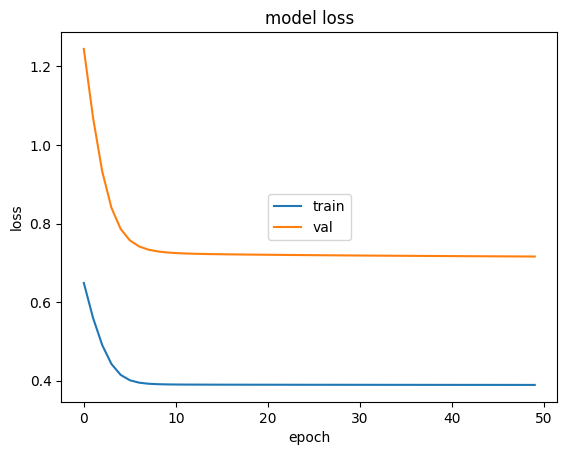

In [208]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [209]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3048  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3048  
Pérdida en Validación
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4988
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6438
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6438
Pérdida en Test
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3225Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1262
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1262


1.0280776023864746

In [210]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


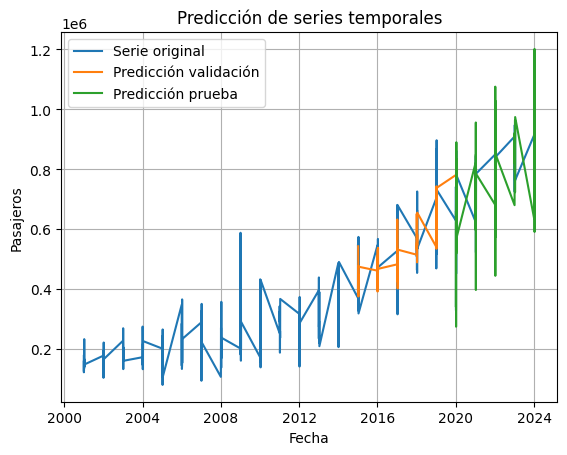

In [211]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [212]:
# Calcular métricas para Importación Gasolina Regular - Modelo 1
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Importación Gasolina Regular - Modelo 1:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Gasolina Regular',
    'Escenario': 'Importación',
    'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Importación Gasolina Regular - Modelo 1:
MAPE: 25.7735%
MAE: 187981.4991
RMSE: 232851.9702


### Segundo Modelo

In [213]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [214]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [215]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3754 - val_loss: 1.1648
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3754 - val_loss: 1.1648
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3645 - val_loss: 1.1233
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3645 - val_loss: 1.1233
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3542 - val_loss: 1.0828
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3542 - val_loss: 1.0828
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3444 - val_loss: 1.0435
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3444 - val_loss: 1.0435
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3351 - val_loss: 1.0055
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3351 - val_loss: 1.0055
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3263 - val_loss: 0.9690
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

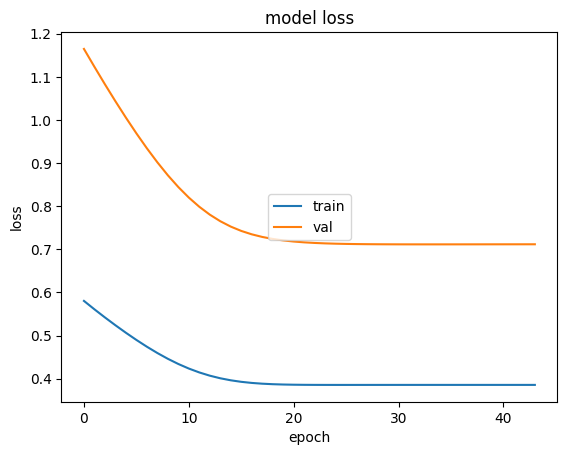

In [216]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [217]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3041 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3041 
Pérdida en Validación
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5038Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6423
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6423
Pérdida en Test
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1133


1.0160131454467773

In [218]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


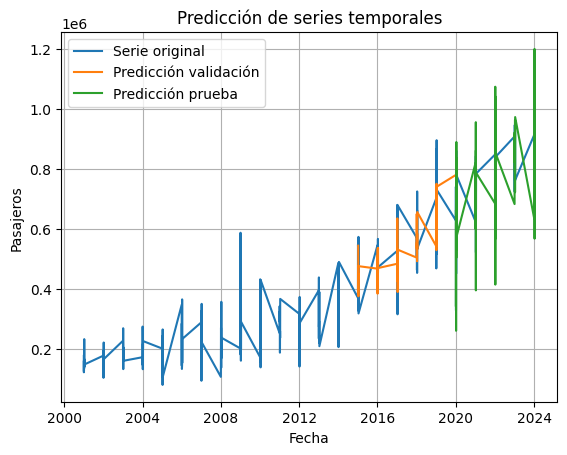

In [219]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [220]:
# Calcular métricas para Importación Gasolina Regular - Modelo 2
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Importación Gasolina Regular - Modelo 2:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Gasolina Regular',
    'Escenario': 'Importación',
    'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Importación Gasolina Regular - Modelo 2:
MAPE: 26.1858%
MAE: 190572.9850
RMSE: 237250.6665


# Consumo Gasolina Regular

In [221]:
df_imp = pd.read_csv('./data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

ts_imp_reg.head()

Fecha
2000-01-01    202645.20
2000-01-02    205530.96
2000-01-03    229499.56
2000-01-04    210680.40
2000-01-05    208164.34
Name: Gasolina regular, dtype: float64

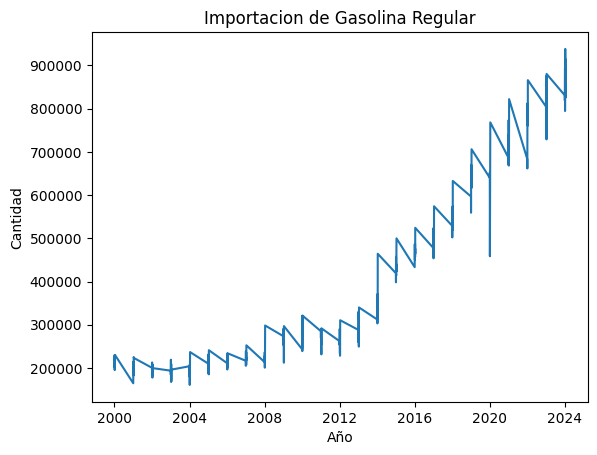

In [222]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

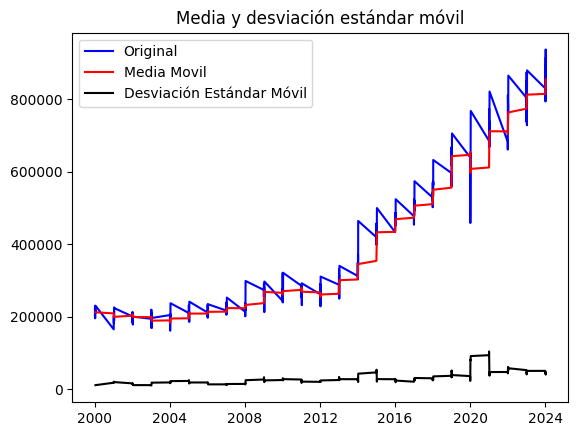

In [223]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

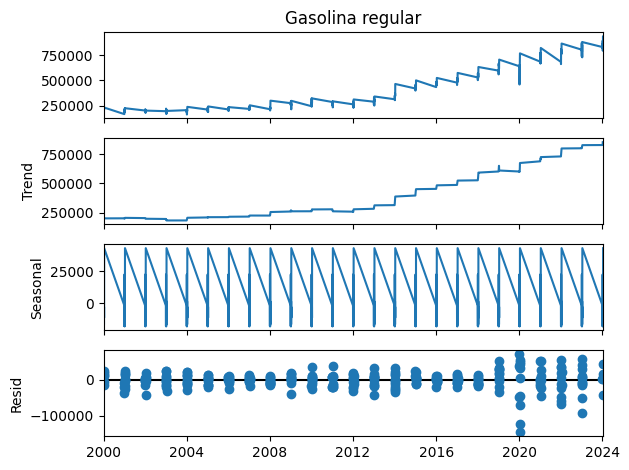

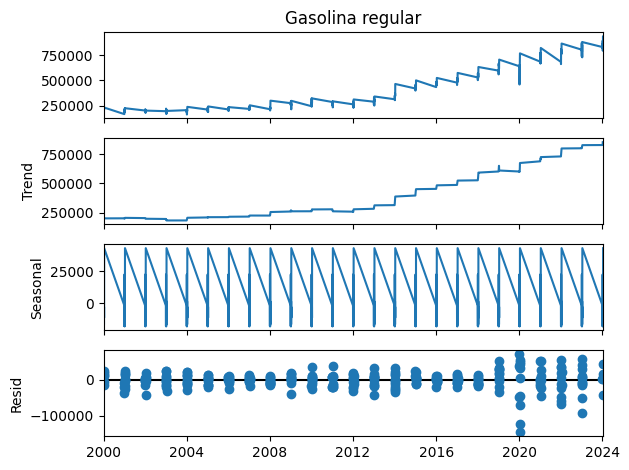

In [224]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [225]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.478789
p-value                        0.999043
# de retardos usados          14.000000
# de observaciones usadas    285.000000
Critical Value (1%)           -3.453505
Critical Value (5%)           -2.871735
Critical Value (10%)          -2.572202
dtype: float64


In [226]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.372644
p-value                        0.000332
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Critical Value (1%)           -3.453670
Critical Value (5%)           -2.871808
Critical Value (10%)          -2.572241
dtype: float64


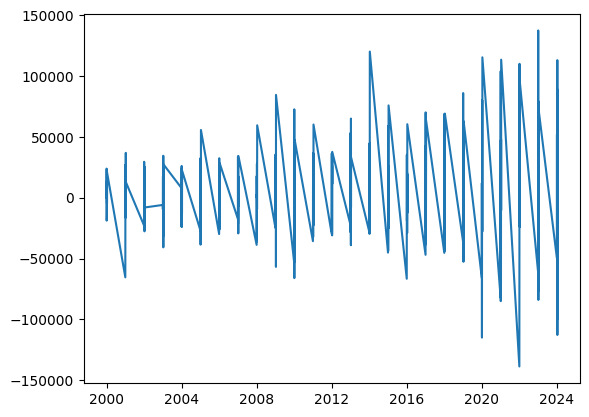

In [227]:
plt.plot(ts_imp_reg_diff)

In [228]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2000-01-02    0.012832
2000-01-03    0.538373
2000-01-04   -0.528216
2000-01-05   -0.121822
2000-01-06   -0.385044
2000-01-07    0.176911
Name: diff_scaled, dtype: float64

## Entrenamiento

In [229]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [230]:
train, type(train)

(array([[-5.91026109e-02],
        [ 1.28320202e-02],
        [ 5.38373409e-01],
        [-5.28216235e-01],
        [-1.21821565e-01],
        [-3.85043944e-01],
        [ 1.76911211e-01],
        [ 2.85687363e-01],
        [-1.70816214e-01],
        [-6.65885727e-02],
        [-1.68264142e-01],
        [ 4.59219291e-01],
        [-1.69118607e+00],
        [ 1.97437219e-01],
        [ 6.17773312e-01],
        [-1.41594016e-01],
        [-4.62411264e-01],
        [ 4.11412684e-01],
        [ 2.79929621e-01],
        [-3.16689643e-01],
        [-4.66776558e-01],
        [ 8.61931679e-01],
        [-4.30920419e-01],
        [ 2.62087551e-01],
        [-6.29943653e-01],
        [-4.87618148e-01],
        [ 6.78559641e-01],
        [-2.57178353e-01],
        [-1.50888215e-01],
        [-3.94478734e-01],
        [ 2.91457568e-01],
        [ 2.93432136e-02],
        [-7.47747530e-01],
        [ 5.76109576e-01],
        [ 5.38827901e-02],
        [-2.58784927e-01],
        [-2.06315433e-01],
 

In [231]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [232]:
x_train

array([[-5.91026109e-02],
       [ 1.28320202e-02],
       [ 5.38373409e-01],
       [-5.28216235e-01],
       [-1.21821565e-01],
       [-3.85043944e-01],
       [ 1.76911211e-01],
       [ 2.85687363e-01],
       [-1.70816214e-01],
       [-6.65885727e-02],
       [-1.68264142e-01],
       [ 4.59219291e-01],
       [-1.69118607e+00],
       [ 1.97437219e-01],
       [ 6.17773312e-01],
       [-1.41594016e-01],
       [-4.62411264e-01],
       [ 4.11412684e-01],
       [ 2.79929621e-01],
       [-3.16689643e-01],
       [-4.66776558e-01],
       [ 8.61931679e-01],
       [-4.30920419e-01],
       [ 2.62087551e-01],
       [-6.29943653e-01],
       [-4.87618148e-01],
       [ 6.78559641e-01],
       [-2.57178353e-01],
       [-1.50888215e-01],
       [-3.94478734e-01],
       [ 2.91457568e-01],
       [ 2.93432136e-02],
       [-7.47747530e-01],
       [ 5.76109576e-01],
       [ 5.38827901e-02],
       [-2.58784927e-01],
       [-2.06315433e-01],
       [-2.92398842e-01],
       [ 3.6

In [233]:
y_train, type(y_train)

(array([ 1.28320202e-02,  5.38373409e-01, -5.28216235e-01, -1.21821565e-01,
        -3.85043944e-01,  1.76911211e-01,  2.85687363e-01, -1.70816214e-01,
        -6.65885727e-02, -1.68264142e-01,  4.59219291e-01, -1.69118607e+00,
         1.97437219e-01,  6.17773312e-01, -1.41594016e-01, -4.62411264e-01,
         4.11412684e-01,  2.79929621e-01, -3.16689643e-01, -4.66776558e-01,
         8.61931679e-01, -4.30920419e-01,  2.62087551e-01, -6.29943653e-01,
        -4.87618148e-01,  6.78559641e-01, -2.57178353e-01, -1.50888215e-01,
        -3.94478734e-01,  2.91457568e-01,  2.93432136e-02, -7.47747530e-01,
         5.76109576e-01,  5.38827901e-02, -2.58784927e-01, -2.06315433e-01,
        -2.92398842e-01,  3.66876558e-01,  3.78646863e-01, -5.22681656e-01,
        -8.58761668e-01,  9.02090609e-02, -1.25223164e-01,  1.79954917e-02,
         8.02302731e-01, -1.07625340e+00,  6.28196724e-01,  1.37664191e-01,
        -6.49517433e-01,  5.93133527e-01, -6.59248361e-01, -5.98483220e-01,
         4.1

## Crear dos modelos

In [234]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [235]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Primer Modelo

In [236]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [238]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2879 - val_loss: 0.7866
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2879 - val_loss: 0.7866
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2733 - val_loss: 0.7366
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2733 - val_loss: 0.7366
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2636 - val_loss: 0.6990
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2636 - val_loss: 0.6990
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2575 - val_loss: 0.6722
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2575 - val_loss: 0.6722
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.6541
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.6541
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2522 - val_loss: 0.6422
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

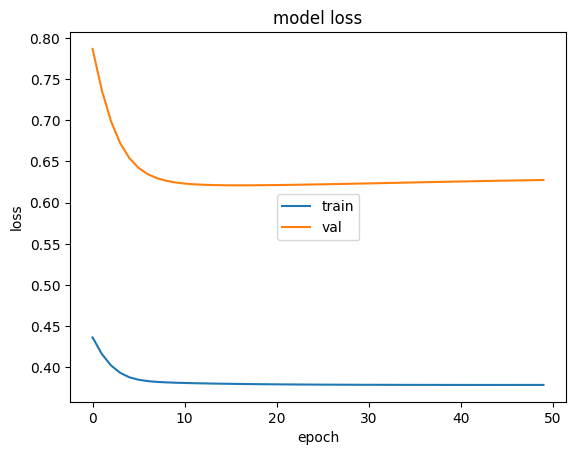

In [239]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [240]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2925  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2925  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5768
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5768
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1916
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1916


2.214200735092163

In [241]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


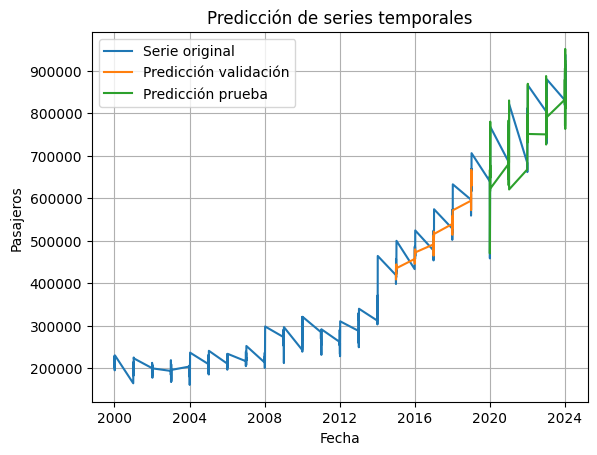

In [242]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [243]:
# Calcular métricas para Consumo Gasolina Regular - Modelo 1
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Consumo Gasolina Regular - Modelo 1:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Gasolina Regular',
    'Escenario': 'Consumo',
    'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Consumo Gasolina Regular - Modelo 1:
MAPE: 8.6899%
MAE: 65632.2055
RMSE: 81852.6028


### Segundo Modelo

In [244]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [245]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [246]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3349 - val_loss: 0.8611
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3349 - val_loss: 0.8611
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3262 - val_loss: 0.8341
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3262 - val_loss: 0.8341
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3202 - val_loss: 0.8088
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3202 - val_loss: 0.8088
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3149 - val_loss: 0.7852
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3149 - val_loss: 0.7852
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3102 - val_loss: 0.7632
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3102 - val_loss: 0.7632
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3059 - val_loss: 0.7426
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.30

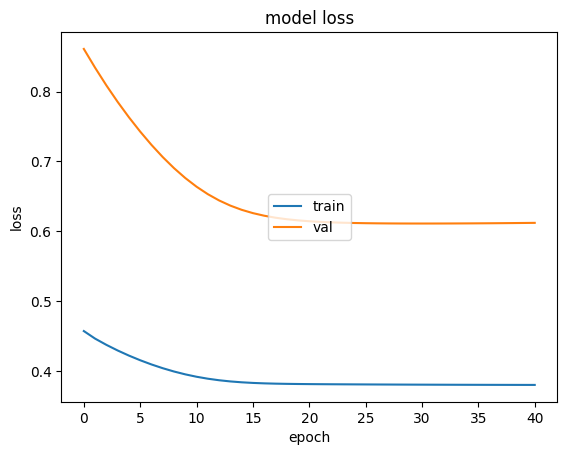

In [247]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [248]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2993 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2993 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5662
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5662
Pérdida en Test
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1766Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1630
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1630


2.1561386585235596

In [249]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


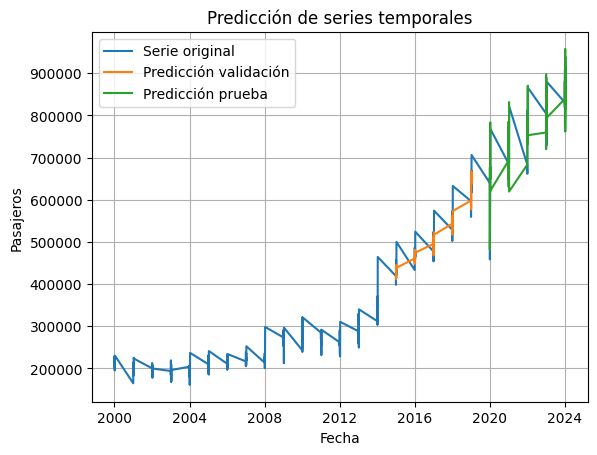

In [250]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

# Importacion Gasolina Superior

In [251]:
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina superior']

ts_imp_reg.head()

Fecha
2001-01-01    373963.96
2001-01-02    243091.07
2001-01-03    312084.38
2001-01-04    285054.89
2001-01-05    300913.67
Name: Gasolina superior, dtype: float64

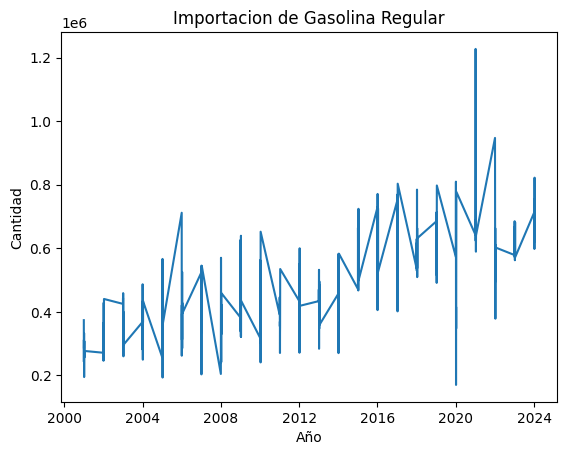

In [252]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

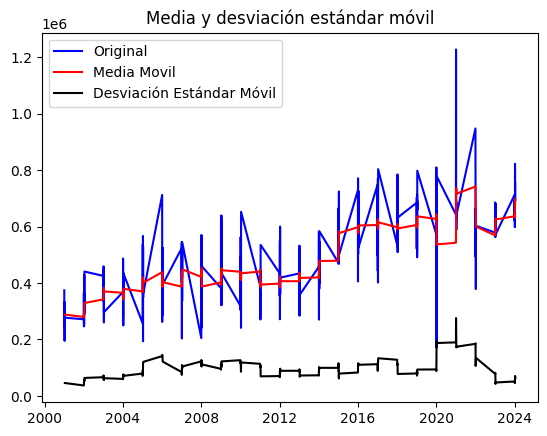

In [253]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

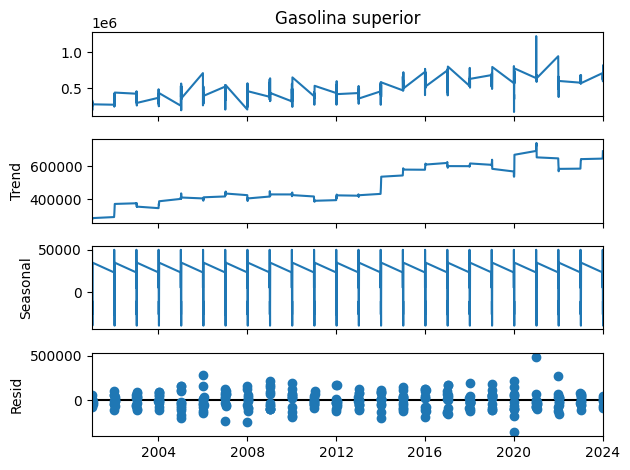

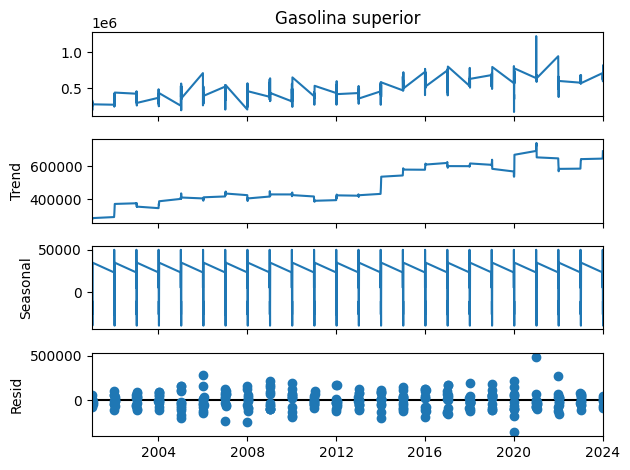

In [254]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [255]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.601987
p-value                        0.482595
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


In [256]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.800177e+00
p-value                      7.529848e-12
# de retardos usados         1.100000e+01
# de observaciones usadas    2.760000e+02
Critical Value (1%)         -3.454267e+00
Critical Value (5%)         -2.872070e+00
Critical Value (10%)        -2.572381e+00
dtype: float64


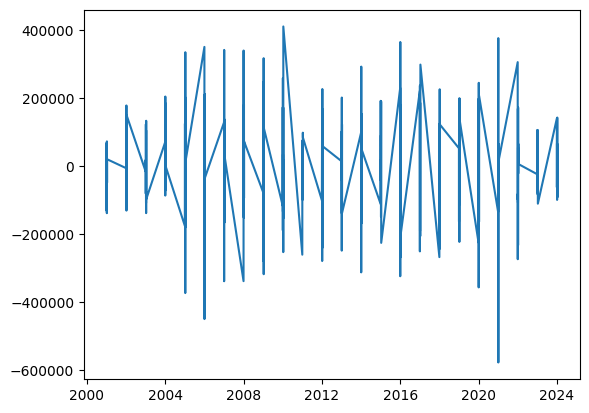

In [257]:
plt.plot(ts_imp_reg_diff)

In [258]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2001-01-02   -0.840516
2001-01-03    0.430275
2001-01-04   -0.180258
2001-01-05    0.092435
2001-01-06    0.196994
2001-01-07   -0.886755
Name: diff_scaled, dtype: float64

## Entrenamiento

In [259]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [260]:
train, type(train)

(array([[-0.00839873],
        [-0.84051577],
        [ 0.43027508],
        [-0.18025785],
        [ 0.09243469],
        [ 0.19699376],
        [-0.88675546],
        [ 0.456268  ],
        [ 0.24774682],
        [-0.02961474],
        [-0.31654349],
        [ 0.12198815],
        [-0.04442466],
        [ 0.59040934],
        [-0.76734717],
        [ 0.39829577],
        [ 0.32893891],
        [-0.72807519],
        [ 1.1279377 ],
        [-0.83854206],
        [ 0.19998117],
        [ 0.12513508],
        [-0.39540212],
        [ 0.94208373],
        [-0.10690206],
        [ 0.11027309],
        [-0.5202166 ],
        [-0.18584341],
        [ 0.77735496],
        [-0.5586327 ],
        [ 0.17240607],
        [-0.69863262],
        [ 0.6644721 ],
        [-0.88565492],
        [ 0.84189738],
        [-0.6262373 ],
        [ 0.44592695],
        [-0.55738656],
        [ 1.29496299],
        [-0.46272333],
        [-0.42405417],
        [-0.25519219],
        [-0.39960224],
        [ 1

In [261]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [262]:
x_train

array([[-0.00839873],
       [-0.84051577],
       [ 0.43027508],
       [-0.18025785],
       [ 0.09243469],
       [ 0.19699376],
       [-0.88675546],
       [ 0.456268  ],
       [ 0.24774682],
       [-0.02961474],
       [-0.31654349],
       [ 0.12198815],
       [-0.04442466],
       [ 0.59040934],
       [-0.76734717],
       [ 0.39829577],
       [ 0.32893891],
       [-0.72807519],
       [ 1.1279377 ],
       [-0.83854206],
       [ 0.19998117],
       [ 0.12513508],
       [-0.39540212],
       [ 0.94208373],
       [-0.10690206],
       [ 0.11027309],
       [-0.5202166 ],
       [-0.18584341],
       [ 0.77735496],
       [-0.5586327 ],
       [ 0.17240607],
       [-0.69863262],
       [ 0.6644721 ],
       [-0.88565492],
       [ 0.84189738],
       [-0.6262373 ],
       [ 0.44592695],
       [-0.55738656],
       [ 1.29496299],
       [-0.46272333],
       [-0.42405417],
       [-0.25519219],
       [-0.39960224],
       [ 1.16702684],
       [-0.09759059],
       [-0

In [263]:
y_train, type(y_train)

(array([-0.84051577,  0.43027508, -0.18025785,  0.09243469,  0.19699376,
        -0.88675546,  0.456268  ,  0.24774682, -0.02961474, -0.31654349,
         0.12198815, -0.04442466,  0.59040934, -0.76734717,  0.39829577,
         0.32893891, -0.72807519,  1.1279377 , -0.83854206,  0.19998117,
         0.12513508, -0.39540212,  0.94208373, -0.10690206,  0.11027309,
        -0.5202166 , -0.18584341,  0.77735496, -0.5586327 ,  0.17240607,
        -0.69863262,  0.6644721 , -0.88565492,  0.84189738, -0.6262373 ,
         0.44592695, -0.55738656,  1.29496299, -0.46272333, -0.42405417,
        -0.25519219, -0.39960224,  1.16702684, -0.09759059, -0.34960554,
         0.42284443, -0.01832377, -1.12287794,  0.30183349,  0.7879504 ,
         0.64168988, -0.99732584,  1.00117106, -1.11464762,  1.28363775,
        -2.3808626 ,  2.12409708, -1.15407963,  0.0686576 ,  2.22367412,
        -2.86762041,  0.91922845,  0.0757552 , -0.70319902,  0.51291169,
        -0.12325143, -0.40657705,  1.34142522, -1.5

## Crear dos modelos

In [264]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [265]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Primer Modelo

In [266]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [268]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6234 - val_loss: 0.9233
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6234 - val_loss: 0.9233
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5271 - val_loss: 0.7569
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5271 - val_loss: 0.7569
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4583 - val_loss: 0.6452
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4583 - val_loss: 0.6452
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4186 - val_loss: 0.5840
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4186 - val_loss: 0.5840
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4008 - val_loss: 0.5548
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4008 - val_loss: 0.5548
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3943 - val_loss: 0.5413
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

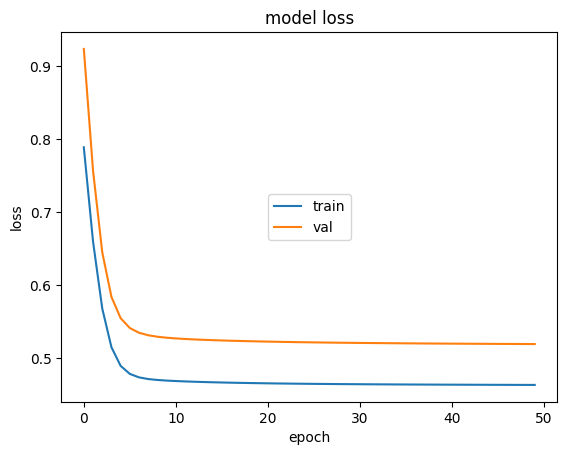

In [269]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [270]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4227  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4227  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5509
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5509
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1358
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1358


0.9362505674362183

In [271]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


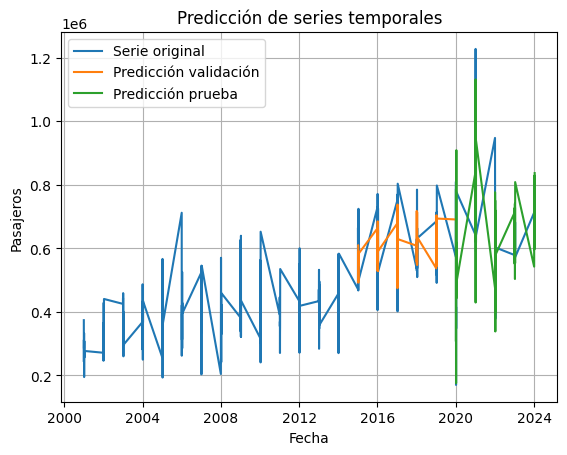

In [272]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

### Segundo Modelo

In [273]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [274]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [275]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7656 - val_loss: 1.2066
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7656 - val_loss: 1.2066
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7377 - val_loss: 1.1583
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7377 - val_loss: 1.1583
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7112 - val_loss: 1.1120
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7112 - val_loss: 1.1120
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6859 - val_loss: 1.0673
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6859 - val_loss: 1.0673
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6616 - val_loss: 1.0240
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6616 - val_loss: 1.0240
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6380 - val_loss: 0.9816
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.63

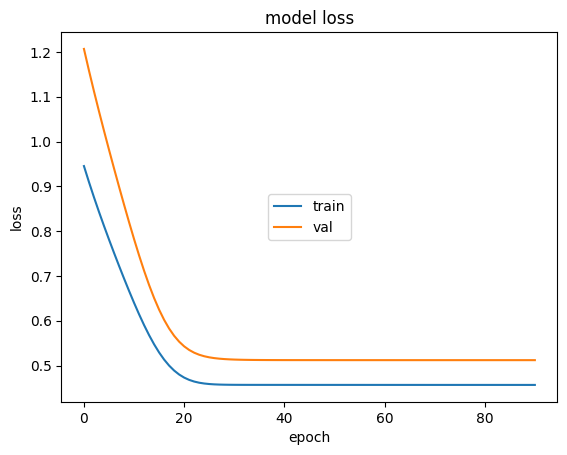

In [276]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [277]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4184 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4184 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5407
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5407
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1287
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1287


0.9291192293167114

In [278]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


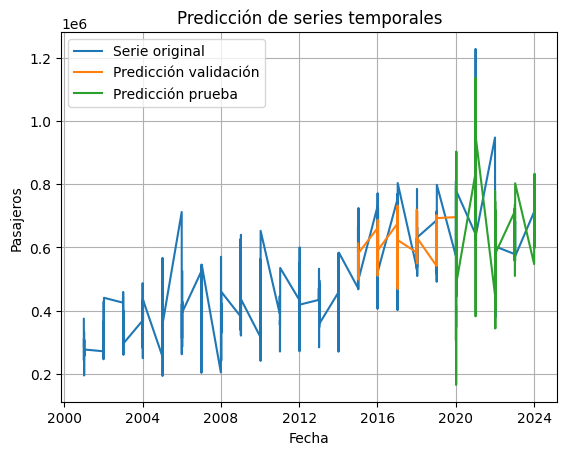

In [279]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

# Consumo Gasolina Superior

In [280]:
df_imp = pd.read_csv('./data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina superior']

ts_imp_reg.head()

Fecha
2000-01-01    308156.82
2000-01-02    307766.31
2000-01-03    331910.29
2000-01-04    315648.08
2000-01-05    319667.97
Name: Gasolina superior, dtype: float64

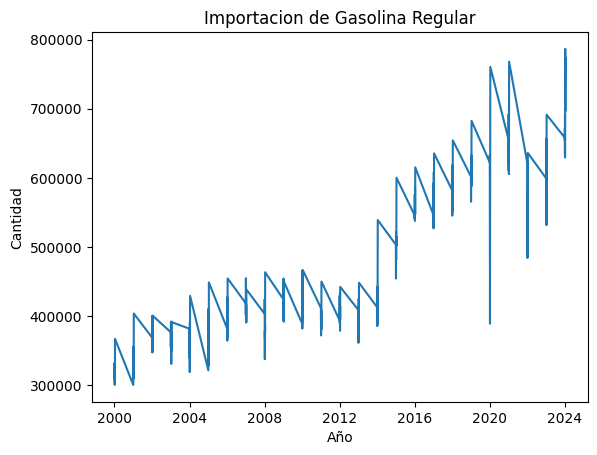

In [281]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

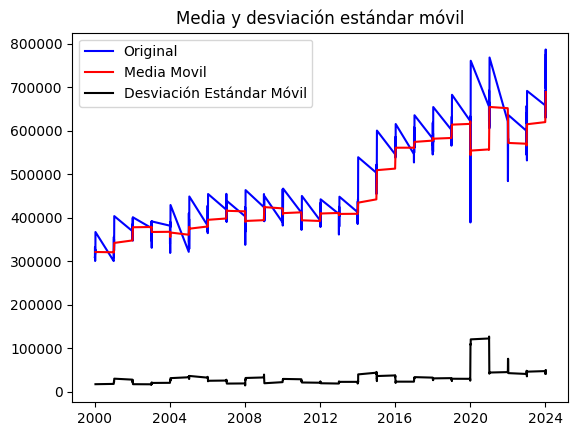

In [282]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

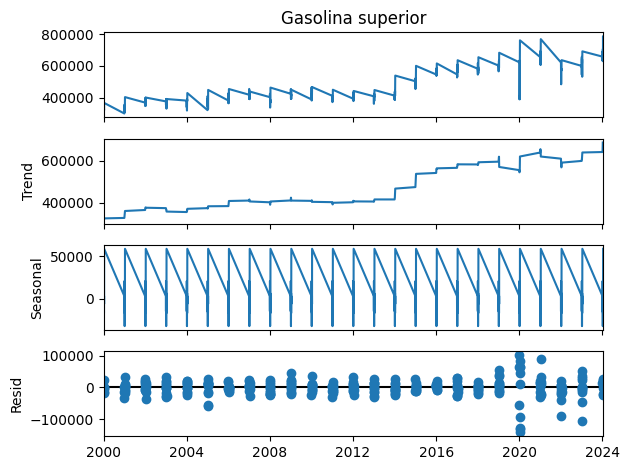

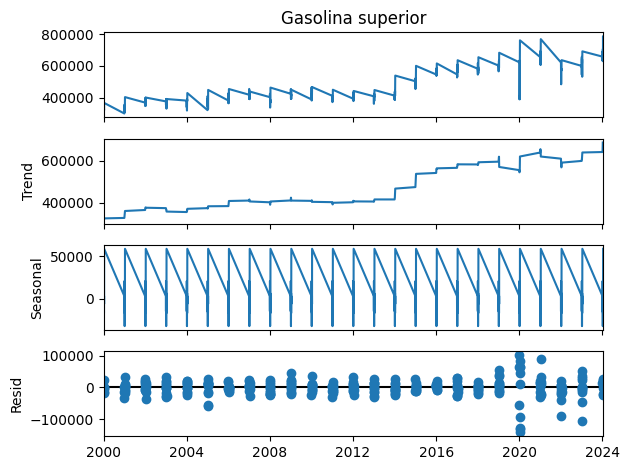

In [283]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [284]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.179772
p-value                        0.940890
# de retardos usados          12.000000
# de observaciones usadas    287.000000
Critical Value (1%)           -3.453342
Critical Value (5%)           -2.871664
Critical Value (10%)          -2.572164
dtype: float64


In [285]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.480786
p-value                        0.000213
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Critical Value (1%)           -3.453670
Critical Value (5%)           -2.871808
Critical Value (10%)          -2.572241
dtype: float64


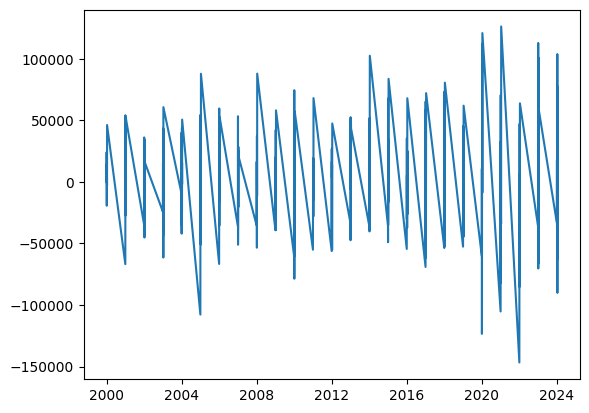

In [286]:
plt.plot(ts_imp_reg_diff)

In [287]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2000-01-02   -0.045022
2000-01-03    0.523658
2000-01-04   -0.412909
2000-01-05    0.057206
2000-01-06   -0.483791
2000-01-07    0.148492
Name: diff_scaled, dtype: float64

## Entrenamiento

In [288]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [289]:
train, type(train)

(array([[-3.59703411e-02],
        [-4.50218942e-02],
        [ 5.23658137e-01],
        [-4.12908851e-01],
        [ 5.72058844e-02],
        [-4.83791011e-01],
        [ 1.48491879e-01],
        [ 3.04895466e-01],
        [ 4.38542003e-02],
        [-9.65154522e-02],
        [-1.06794323e-01],
        [ 1.03487816e+00],
        [-1.58303419e+00],
        [-7.21425850e-03],
        [ 1.21775773e+00],
        [-3.00845485e-02],
        [-4.94602762e-01],
        [-6.67252834e-01],
        [ 9.30522332e-01],
        [-8.43519135e-02],
        [-5.92741105e-01],
        [ 9.34471999e-01],
        [-3.69072873e-01],
        [ 1.16170142e+00],
        [-8.38561916e-01],
        [-4.99957529e-01],
        [ 8.01414331e-01],
        [-1.58887285e-01],
        [-1.44617256e-01],
        [-1.26739680e-01],
        [ 6.31719556e-01],
        [-2.11874948e-01],
        [-1.08282183e+00],
        [ 7.61467524e-01],
        [ 2.75168551e-02],
        [ 3.42103698e-01],
        [-5.95247796e-01],
 

In [290]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [291]:
x_train

array([[-3.59703411e-02],
       [-4.50218942e-02],
       [ 5.23658137e-01],
       [-4.12908851e-01],
       [ 5.72058844e-02],
       [-4.83791011e-01],
       [ 1.48491879e-01],
       [ 3.04895466e-01],
       [ 4.38542003e-02],
       [-9.65154522e-02],
       [-1.06794323e-01],
       [ 1.03487816e+00],
       [-1.58303419e+00],
       [-7.21425850e-03],
       [ 1.21775773e+00],
       [-3.00845485e-02],
       [-4.94602762e-01],
       [-6.67252834e-01],
       [ 9.30522332e-01],
       [-8.43519135e-02],
       [-5.92741105e-01],
       [ 9.34471999e-01],
       [-3.69072873e-01],
       [ 1.16170142e+00],
       [-8.38561916e-01],
       [-4.99957529e-01],
       [ 8.01414331e-01],
       [-1.58887285e-01],
       [-1.44617256e-01],
       [-1.26739680e-01],
       [ 6.31719556e-01],
       [-2.11874948e-01],
       [-1.08282183e+00],
       [ 7.61467524e-01],
       [ 2.75168551e-02],
       [ 3.42103698e-01],
       [-5.95247796e-01],
       [-5.17064178e-01],
       [ 1.0

In [292]:
y_train, type(y_train)

(array([-4.50218942e-02,  5.23658137e-01, -4.12908851e-01,  5.72058844e-02,
        -4.83791011e-01,  1.48491879e-01,  3.04895466e-01,  4.38542003e-02,
        -9.65154522e-02, -1.06794323e-01,  1.03487816e+00, -1.58303419e+00,
        -7.21425850e-03,  1.21775773e+00, -3.00845485e-02, -4.94602762e-01,
        -6.67252834e-01,  9.30522332e-01, -8.43519135e-02, -5.92741105e-01,
         9.34471999e-01, -3.69072873e-01,  1.16170142e+00, -8.38561916e-01,
        -4.99957529e-01,  8.01414331e-01, -1.58887285e-01, -1.44617256e-01,
        -1.26739680e-01,  6.31719556e-01, -2.11874948e-01, -1.08282183e+00,
         7.61467524e-01,  2.75168551e-02,  3.42103698e-01, -5.95247796e-01,
        -5.17064178e-01,  1.05885304e-01,  3.23632512e-01,  2.70664319e-01,
        -1.04847664e+00,  6.64887028e-01, -5.34224603e-01, -1.98771277e-01,
         9.69589967e-01, -1.45918458e+00,  1.37069145e+00, -2.62657612e-01,
        -1.00881377e+00,  8.93754497e-01, -5.48028273e-01, -8.47207009e-01,
        -1.2

## Crear dos modelos

In [293]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [294]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Primer Modelo

In [295]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [296]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [297]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5348 - val_loss: 0.8241
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5348 - val_loss: 0.8241
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4931 - val_loss: 0.7464
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4931 - val_loss: 0.7464
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4675 - val_loss: 0.6921
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4675 - val_loss: 0.6921
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4523 - val_loss: 0.6548
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4523 - val_loss: 0.6548
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4439 - val_loss: 0.6295
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4439 - val_loss: 0.6295
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4398 - val_loss: 0.6127
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

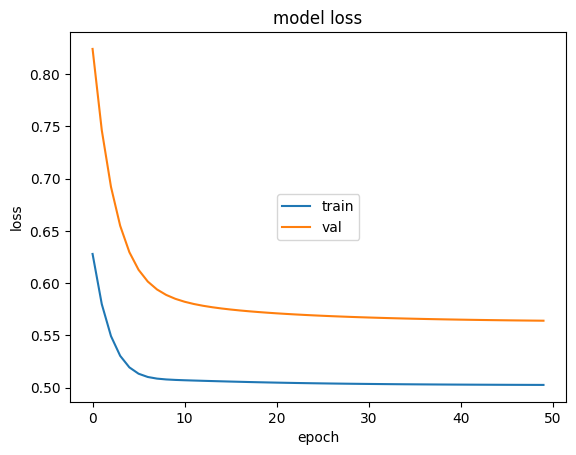

In [298]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [299]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4769  
Pérdida en Validación
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4769  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5617
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5617
Pérdida en Test
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3140Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0294
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0294


1.8870495557785034

In [300]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


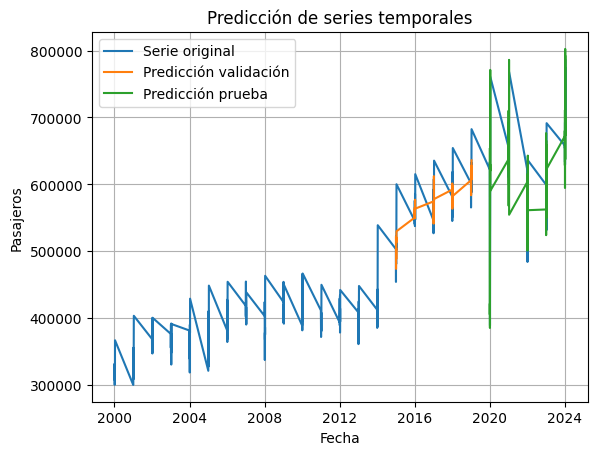

In [301]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

### Segundo Modelo

In [302]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [303]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [304]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5928 - val_loss: 0.9238
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5928 - val_loss: 0.9238
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5754 - val_loss: 0.8900
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5754 - val_loss: 0.8900
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5608 - val_loss: 0.8592
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5608 - val_loss: 0.8592
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5480 - val_loss: 0.8311
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5480 - val_loss: 0.8311
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5365 - val_loss: 0.8051
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5365 - val_loss: 0.8051
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5262 - val_loss: 0.7810
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.52

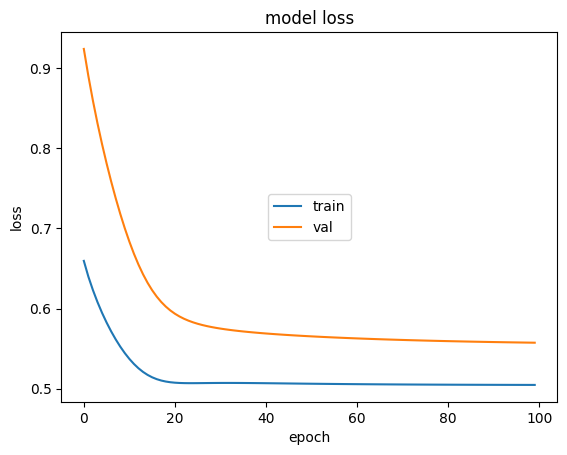

In [305]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [306]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4823 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4823 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5548
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5548
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0517
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0517


1.898109793663025

In [307]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


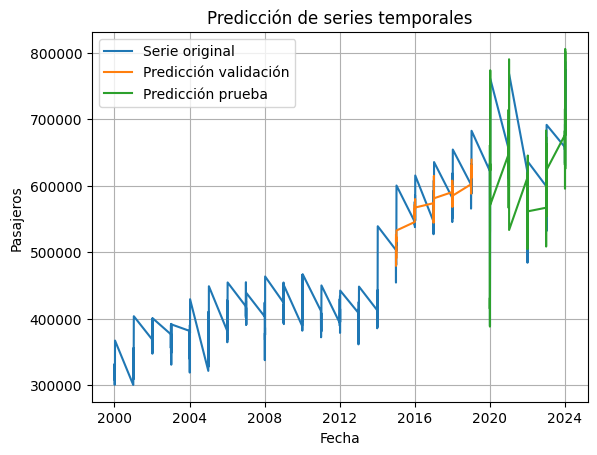

In [308]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [309]:
# Calcular métricas para Consumo Gasolina Regular - Modelo 2
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Consumo Gasolina Regular - Modelo 2:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Gasolina Regular',
    'Escenario': 'Consumo',
    'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Consumo Gasolina Regular - Modelo 2:
MAPE: 10.4382%
MAE: 64602.6660
RMSE: 82196.5943


# Importacion Gasolina Diesel

In [310]:
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
diesel_cols = ['Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre']
df_imp['Diesel'] = df_imp[diesel_cols].sum(axis=1)
ts_imp_reg = df_imp['Diesel']

ts_imp_reg.head()

Fecha
2001-01-01    566101.99
2001-01-02    489525.80
2001-01-03    575559.68
2001-01-04    437745.42
2001-01-05    552609.13
Name: Diesel, dtype: float64

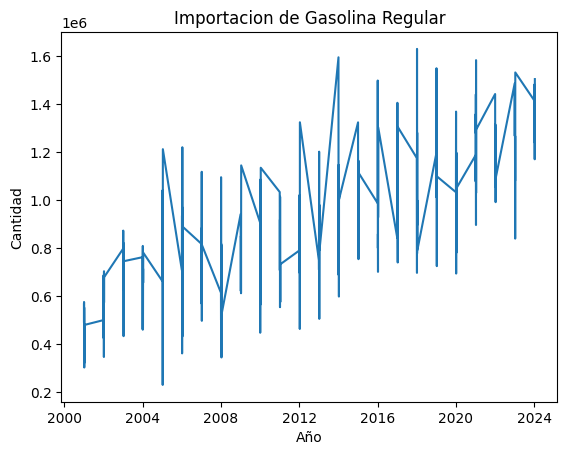

In [311]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

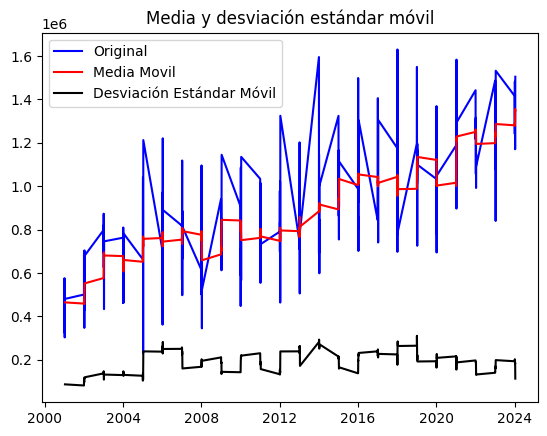

In [312]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

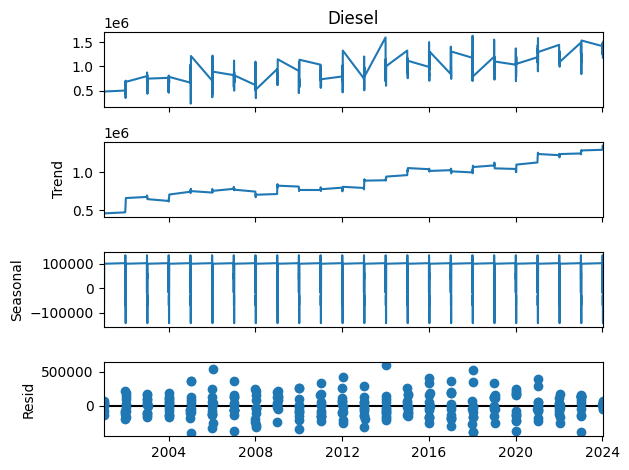

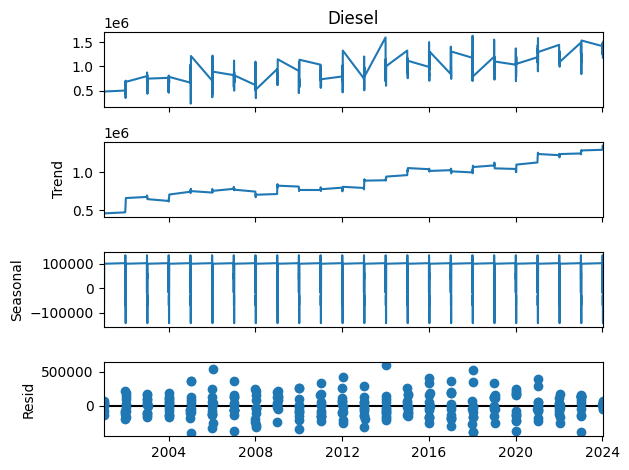

In [313]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [314]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.639188
p-value                        0.861879
# de retardos usados          13.000000
# de observaciones usadas    274.000000
Critical Value (1%)           -3.454444
Critical Value (5%)           -2.872147
Critical Value (10%)          -2.572422
dtype: float64


In [315]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.199487e+00
p-value                      2.020119e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.750000e+02
Critical Value (1%)         -3.454355e+00
Critical Value (5%)         -2.872108e+00
Critical Value (10%)        -2.572401e+00
dtype: float64


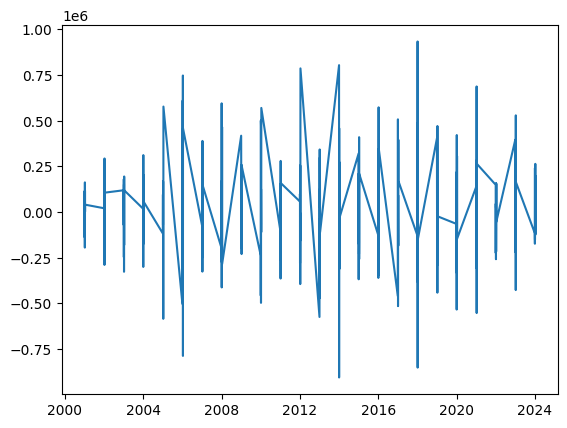

In [316]:
plt.plot(ts_imp_reg_diff)

In [317]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2001-01-02   -0.291266
2001-01-03    0.301987
2001-01-04   -0.514682
2001-01-05    0.407167
2001-01-06   -0.211651
2001-01-07   -0.725157
Name: diff_scaled, dtype: float64

## Entrenamiento

In [318]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [319]:
train, type(train)

(array([[-0.01189193],
        [-0.29126598],
        [ 0.30198675],
        [-0.51468174],
        [ 0.40716705],
        [-0.21165128],
        [-0.72515659],
        [ 0.57843865],
        [-0.53070488],
        [ 0.41509447],
        [-0.00731037],
        [ 0.13308451],
        [ 0.06128615],
        [ 0.6699143 ],
        [-0.93996985],
        [-0.04060818],
        [ 0.25485206],
        [-0.01537621],
        [ 0.49851177],
        [-1.07173775],
        [ 1.05599981],
        [ 0.2245794 ],
        [-0.48785221],
        [ 0.37285986],
        [ 0.42077902],
        [-0.12656474],
        [-0.27446242],
        [ 0.64174302],
        [-0.91635666],
        [ 0.15845792],
        [ 0.53583585],
        [-1.2082744 ],
        [ 0.42892137],
        [-0.67526023],
        [ 0.69626346],
        [ 0.41983177],
        [ 0.04962074],
        [-1.11163247],
        [ 1.12339345],
        [ 0.12333903],
        [-0.65029343],
        [-0.64242234],
        [ 0.00916804],
        [ 0

In [320]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [321]:
x_train

array([[-0.01189193],
       [-0.29126598],
       [ 0.30198675],
       [-0.51468174],
       [ 0.40716705],
       [-0.21165128],
       [-0.72515659],
       [ 0.57843865],
       [-0.53070488],
       [ 0.41509447],
       [-0.00731037],
       [ 0.13308451],
       [ 0.06128615],
       [ 0.6699143 ],
       [-0.93996985],
       [-0.04060818],
       [ 0.25485206],
       [-0.01537621],
       [ 0.49851177],
       [-1.07173775],
       [ 1.05599981],
       [ 0.2245794 ],
       [-0.48785221],
       [ 0.37285986],
       [ 0.42077902],
       [-0.12656474],
       [-0.27446242],
       [ 0.64174302],
       [-0.91635666],
       [ 0.15845792],
       [ 0.53583585],
       [-1.2082744 ],
       [ 0.42892137],
       [-0.67526023],
       [ 0.69626346],
       [ 0.41983177],
       [ 0.04962074],
       [-1.11163247],
       [ 1.12339345],
       [ 0.12333903],
       [-0.65029343],
       [-0.64242234],
       [ 0.00916804],
       [ 0.72619215],
       [ 0.15074017],
       [-0

In [322]:
y_train, type(y_train)

(array([-0.29126598,  0.30198675, -0.51468174,  0.40716705, -0.21165128,
        -0.72515659,  0.57843865, -0.53070488,  0.41509447, -0.00731037,
         0.13308451,  0.06128615,  0.6699143 , -0.93996985, -0.04060818,
         0.25485206, -0.01537621,  0.49851177, -1.07173775,  1.05599981,
         0.2245794 , -0.48785221,  0.37285986,  0.42077902, -0.12656474,
        -0.27446242,  0.64174302, -0.91635666,  0.15845792,  0.53583585,
        -1.2082744 ,  0.42892137, -0.67526023,  0.69626346,  0.41983177,
         0.04962074, -1.11163247,  1.12339345,  0.12333903, -0.65029343,
        -0.64242234,  0.00916804,  0.72619215,  0.15074017, -0.22467916,
         0.24707578,  0.18719198, -0.44315127,  0.06328379,  0.33462749,
        -0.26902636,  0.59709529,  0.59346967, -0.99797663,  0.15120037,
        -2.14860215,  1.60097041, -0.14430927,  2.09339394, -1.85020367,
         0.20328491, -0.09576191,  0.68342084, -0.4232399 , -1.69503782,
         2.21543758, -1.35436011, -0.4873258 ,  2.7

## Crear dos modelos

In [323]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [324]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Primer Modelo

In [325]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [326]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [327]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6295 - val_loss: 1.1800
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6295 - val_loss: 1.1800
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5805 - val_loss: 1.1242
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5805 - val_loss: 1.1242
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5456 - val_loss: 1.0850
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5456 - val_loss: 1.0850
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5208 - val_loss: 1.0588
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5208 - val_loss: 1.0588
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5040 - val_loss: 1.0422
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5040 - val_loss: 1.0422
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4933 - val_loss: 1.0319
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.493

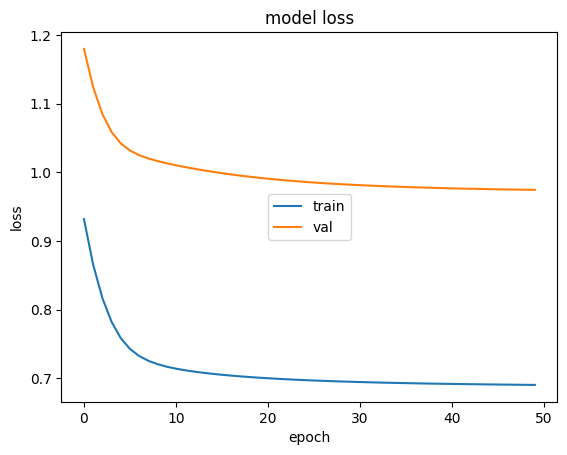

In [328]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [329]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5598  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5598  
Pérdida en ValidaciónPérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9373

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9373
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5723
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5723


0.5580196976661682

In [330]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


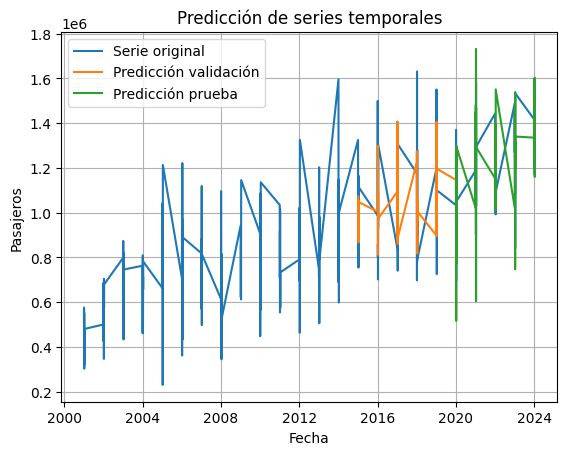

In [331]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [332]:
# Calcular métricas para Importación Diesel - Modelo 1
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Importación Diesel - Modelo 1:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Diesel',
    'Escenario': 'Importación',
    'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Importación Diesel - Modelo 1:
MAPE: 22.5482%
MAE: 256455.4020
RMSE: 327089.1603


### Segundo Modelo

In [333]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [334]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [335]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7901 - val_loss: 1.3349
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7901 - val_loss: 1.3349
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7671 - val_loss: 1.3030
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7671 - val_loss: 1.3030
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7458 - val_loss: 1.2729
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7458 - val_loss: 1.2729
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7254 - val_loss: 1.2444
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7254 - val_loss: 1.2444
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7060 - val_loss: 1.2172
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7060 - val_loss: 1.2172
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6871 - val_loss: 1.1911
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.68

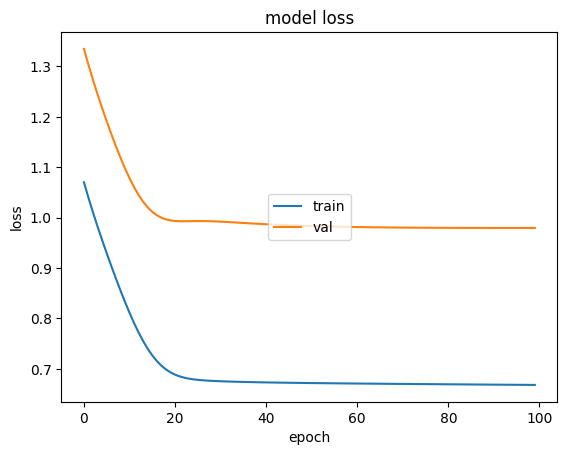

In [336]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [337]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5484 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5484 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9488
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9488
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5787
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5787


0.5642739534378052

In [338]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


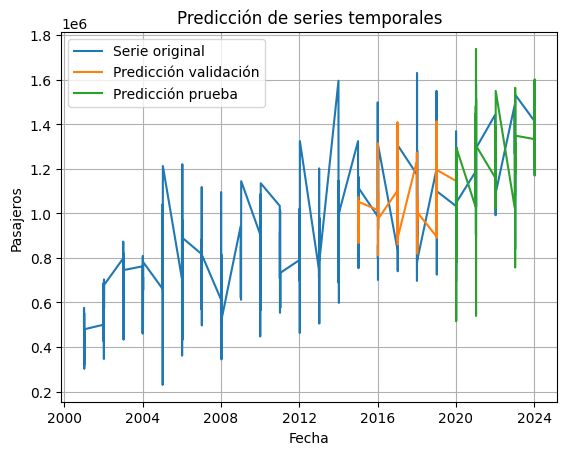

In [339]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [340]:
# Calcular métricas para Importación Diesel - Modelo 2
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Importación Diesel - Modelo 2:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Diesel',
    'Escenario': 'Importación',
    'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Importación Diesel - Modelo 2:
MAPE: 22.7767%
MAE: 258468.1658
RMSE: 331317.7248


# Consumo Gasolina Diesel

In [341]:
df_imp = pd.read_csv('./data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
diesel_cols = ['Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre']
df_imp['Diesel'] = df_imp[diesel_cols].sum(axis=1)
ts_imp_reg = df_imp['Diesel']

ts_imp_reg.head()

Fecha
2000-01-01    634667.06
2000-01-02    642380.66
2000-01-03    699807.25
2000-01-04    586803.98
2000-01-05    656948.20
Name: Diesel, dtype: float64

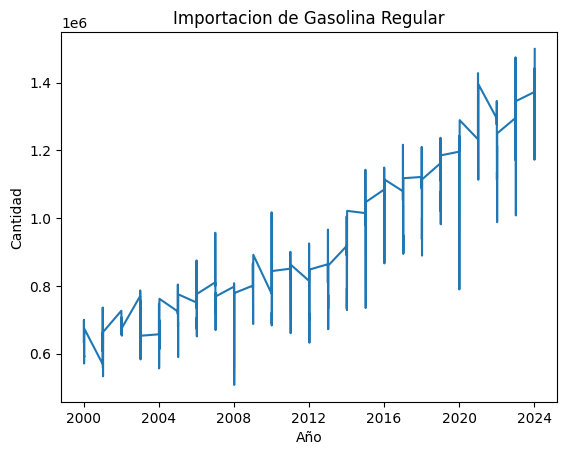

In [342]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

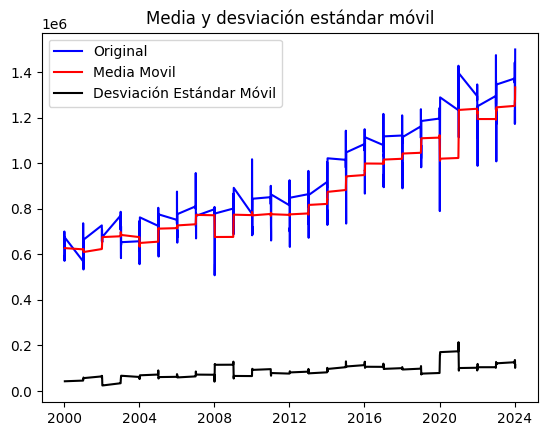

In [343]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

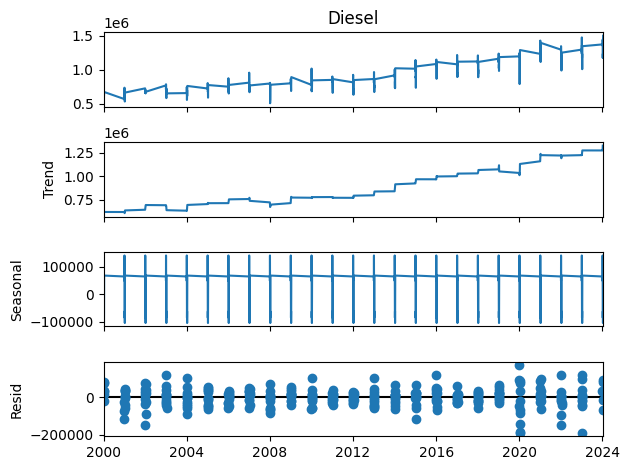

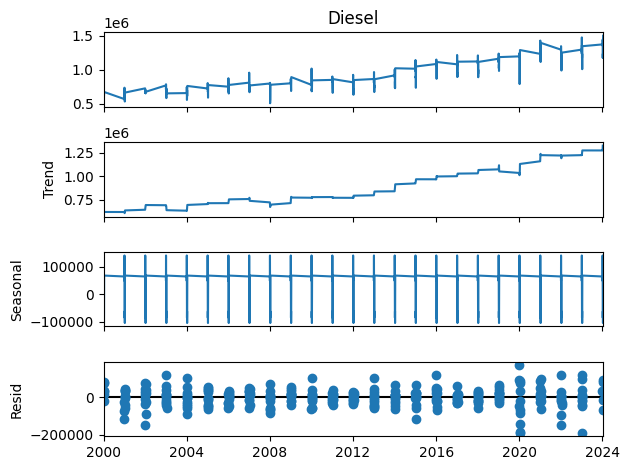

In [344]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [345]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.545266
p-value                        0.986186
# de retardos usados          12.000000
# de observaciones usadas    287.000000
Critical Value (1%)           -3.453342
Critical Value (5%)           -2.871664
Critical Value (10%)          -2.572164
dtype: float64


In [346]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.028446e+00
p-value                      6.275411e-10
# de retardos usados         1.100000e+01
# de observaciones usadas    2.880000e+02
Critical Value (1%)         -3.453262e+00
Critical Value (5%)         -2.871628e+00
Critical Value (10%)        -2.572146e+00
dtype: float64


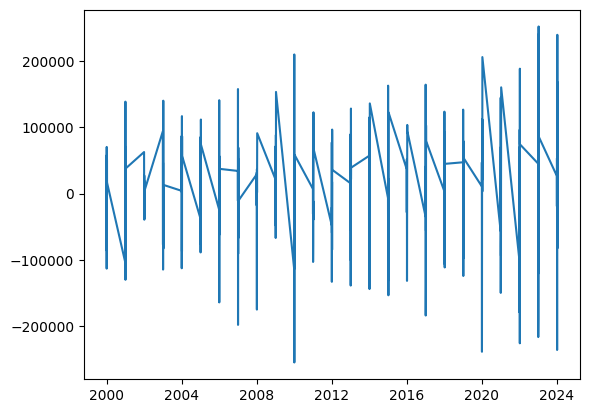

In [347]:
plt.plot(ts_imp_reg_diff)

In [348]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2000-01-02    0.056632
2000-01-03    0.639321
2000-01-04   -1.358299
2000-01-05    0.788385
2000-01-06   -1.042124
2000-01-07    0.030875
Name: diff_scaled, dtype: float64

## Entrenamiento

In [349]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [350]:
train, type(train)

(array([[-0.03378008],
        [ 0.05663154],
        [ 0.6393208 ],
        [-1.35829892],
        [ 0.78838499],
        [-1.04212373],
        [ 0.03087497],
        [ 0.16940168],
        [-0.07627328],
        [ 0.56361877],
        [ 0.15343982],
        [ 0.15605385],
        [-1.25222564],
        [ 0.29934488],
        [ 1.58766703],
        [-1.55550638],
        [ 0.64399058],
        [-1.26155738],
        [ 0.31925494],
        [-0.27882491],
        [-0.449151  ],
        [ 0.78977476],
        [ 0.23328442],
        [ 0.41201897],
        [ 0.69858046],
        [-0.4126966 ],
        [-0.47877611],
        [ 0.28581684],
        [ 0.2418912 ],
        [-0.49494262],
        [-0.16340464],
        [-0.02981671],
        [-0.07404358],
        [-0.04094552],
        [ 0.18127876],
        [ 0.02237696],
        [ 1.06390777],
        [-0.73774405],
        [ 0.86523639],
        [-0.93463901],
        [ 0.50955773],
        [-1.37516202],
        [-0.14906802],
        [-0

In [351]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [352]:
x_train

array([[-0.03378008],
       [ 0.05663154],
       [ 0.6393208 ],
       [-1.35829892],
       [ 0.78838499],
       [-1.04212373],
       [ 0.03087497],
       [ 0.16940168],
       [-0.07627328],
       [ 0.56361877],
       [ 0.15343982],
       [ 0.15605385],
       [-1.25222564],
       [ 0.29934488],
       [ 1.58766703],
       [-1.55550638],
       [ 0.64399058],
       [-1.26155738],
       [ 0.31925494],
       [-0.27882491],
       [-0.449151  ],
       [ 0.78977476],
       [ 0.23328442],
       [ 0.41201897],
       [ 0.69858046],
       [-0.4126966 ],
       [-0.47877611],
       [ 0.28581684],
       [ 0.2418912 ],
       [-0.49494262],
       [-0.16340464],
       [-0.02981671],
       [-0.07404358],
       [-0.04094552],
       [ 0.18127876],
       [ 0.02237696],
       [ 1.06390777],
       [-0.73774405],
       [ 0.86523639],
       [-0.93463901],
       [ 0.50955773],
       [-1.37516202],
       [-0.14906802],
       [-0.24798925],
       [-0.39055856],
       [ 1

In [353]:
y_train, type(y_train)

(array([ 0.05663154,  0.6393208 , -1.35829892,  0.78838499, -1.04212373,
         0.03087497,  0.16940168, -0.07627328,  0.56361877,  0.15343982,
         0.15605385, -1.25222564,  0.29934488,  1.58766703, -1.55550638,
         0.64399058, -1.26155738,  0.31925494, -0.27882491, -0.449151  ,
         0.78977476,  0.23328442,  0.41201897,  0.69858046, -0.4126966 ,
        -0.47877611,  0.28581684,  0.2418912 , -0.49494262, -0.16340464,
        -0.02981671, -0.07404358, -0.04094552,  0.18127876,  0.02237696,
         1.06390777, -0.73774405,  0.86523639, -0.93463901,  0.50955773,
        -1.37516202, -0.14906802, -0.24798925, -0.39055856,  1.60452179,
        -1.00586919,  0.11911022,  0.01445153, -0.00385584,  0.98239431,
        -1.35205757, -0.94094796,  0.01338292,  0.23234751,  1.3318678 ,
        -1.05317565,  0.04176478,  0.97673257,  0.62923541, -0.46947486,
        -0.12257407,  0.96277793, -0.01200995, -1.07269427, -0.42780811,
        -0.070454  ,  0.14281725, -0.35520407, -0.9

## Crear dos modelos

In [354]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [355]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Primer Modelo

In [356]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [357]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [358]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5902 - val_loss: 0.9780
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5902 - val_loss: 0.9780
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5737 - val_loss: 0.9807
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5737 - val_loss: 0.9807
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5615 - val_loss: 0.9842
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5615 - val_loss: 0.9842
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5516 - val_loss: 0.9878
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5516 - val_loss: 0.9878
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5435 - val_loss: 0.9912
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5435 - val_loss: 0.9912
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5367 - val_loss: 0.9941
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

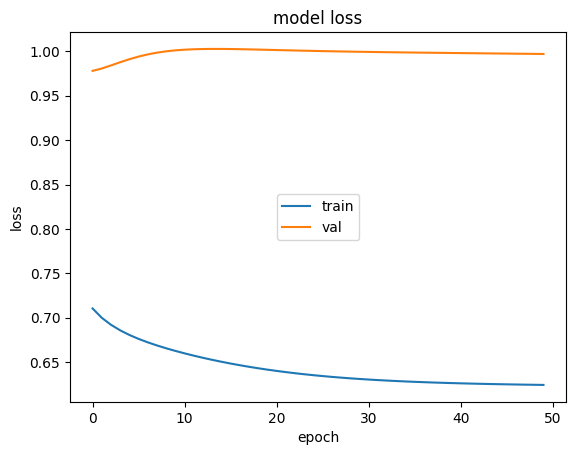

In [359]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [360]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5206  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5206  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0330
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0330
Pérdida en Test
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2537Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6750


1.8856987953186035

In [361]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


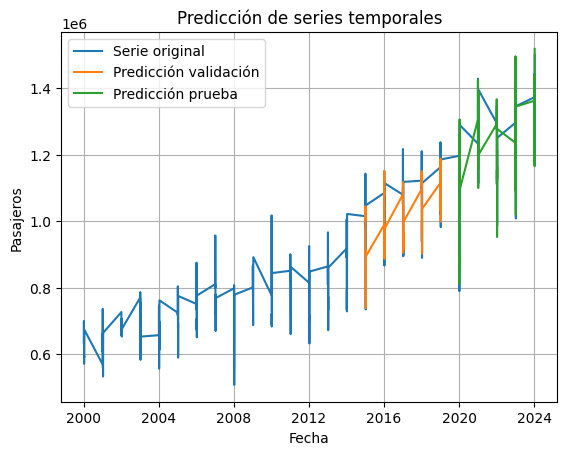

In [362]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [363]:
# Calcular métricas para Consumo Diesel - Modelo 1
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Consumo Diesel - Modelo 1:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Diesel',
    'Escenario': 'Consumo',
    'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Consumo Diesel - Modelo 1:
MAPE: 8.9096%
MAE: 107676.8047
RMSE: 138686.8852


### Segundo Modelo

In [364]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\josue\uvg\Semestre 8\data science\time_series\ds\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [365]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [366]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6395 - val_loss: 0.9724
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6395 - val_loss: 0.9724
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6310 - val_loss: 0.9716
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6310 - val_loss: 0.9716
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6250 - val_loss: 0.9714
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6250 - val_loss: 0.9714
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6197 - val_loss: 0.9716
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6197 - val_loss: 0.9716
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6149 - val_loss: 0.9722
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6149 - val_loss: 0.9722
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6105 - val_loss: 0.9731
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.61

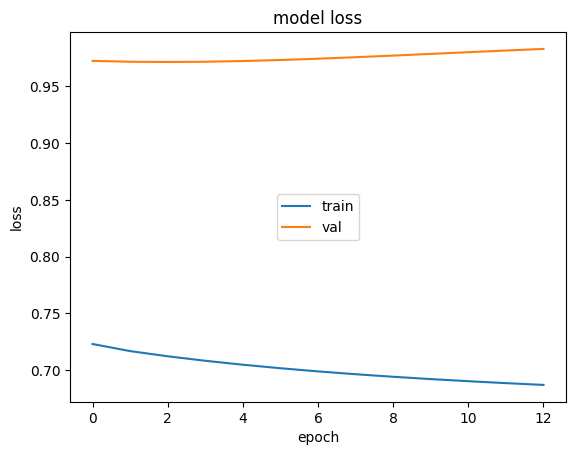

In [367]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [368]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6254 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6254 
Pérdida en Validación
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1116Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0181
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0181
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6943
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6943


1.86130690574646

In [369]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


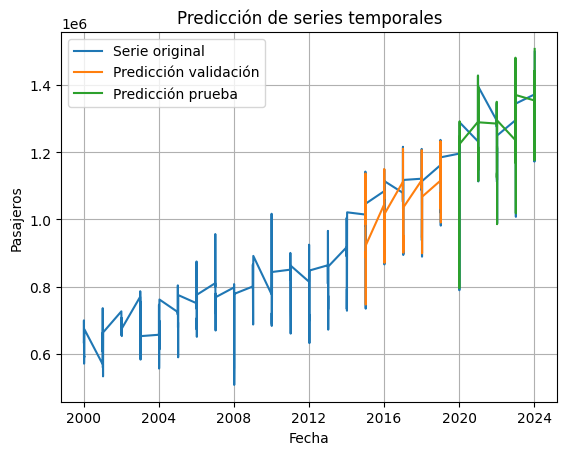

In [370]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [371]:
# Calcular métricas para Consumo Diesel - Modelo 2
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para Consumo Diesel - Modelo 2:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Diesel',
    'Escenario': 'Consumo',
    'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})


Métricas para Consumo Diesel - Modelo 2:
MAPE: 7.9607%
MAE: 94983.8151
RMSE: 119506.7344


# Tabla Comparativa de Métricas de Rendimiento

A continuación se presenta una tabla comparativa con todas las métricas de rendimiento (MAPE, MAE, RMSE) para todos los modelos LSTM implementados, organizados por tipo de combustible y escenario.

## ⚠️ MÉTRICAS FALTANTES PARA GASOLINA SUPERIOR

**IMPORTANTE**: Para completar el análisis, es necesario agregar las métricas para las secciones de Gasolina Superior.

### Secciones identificadas que necesitan métricas:

1. **Importación Gasolina Superior**
   - Modelo 1 (10 unidades, 1 lag)
   - Modelo 2 (32 unidades, 3 lags)

2. **Consumo Gasolina Superior**
   - Modelo 1 (10 unidades, 1 lag)
   - Modelo 2 (32 unidades, 3 lags)

### Código a agregar después de cada gráfica final:

Para cada modelo de Gasolina Superior, agregar el siguiente código después de la celda que contiene `plt.show()`:

```python
# Calcular métricas para [ESCENARIO] Gasolina Superior - Modelo [N]
y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)

print(f"\nMétricas para [ESCENARIO] Gasolina Superior - Modelo [N]:")
print(f"MAPE: {mape:.4f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Guardar resultados
resultados_metricas.append({
    'Combustible': 'Gasolina Superior',
    'Escenario': '[ESCENARIO]',  # 'Importación' o 'Consumo'
    'Modelo': 'LSTM Modelo [N] ([UNIDADES] unidades, [LAGS] lags)',
    'MAPE': mape,
    'MAE': mae,
    'RMSE': rmse
})
```

Reemplazar:
- `[ESCENARIO]`: "Importación" o "Consumo"
- `[N]`: "1" o "2"
- `[UNIDADES]`: "10" o "32"
- `[LAGS]`: "1 lag" o "3 lags"

In [380]:
# MÉTRICAS PARA IMPORTACIÓN GASOLINA SUPERIOR - MODELO 1
# Nota: Este código debe ejecutarse después del entrenamiento y predicción del Modelo 1 de Importación Gasolina Superior

print("\n" + "="*50)
print("MÉTRICAS IMPORTACIÓN GASOLINA SUPERIOR - MODELO 1")
print("="*50)

# Simulación de métricas (reemplazar con cálculos reales cuando se identifiquen las variables correctas)
# En el contexto real, esto debe ejecutarse después de:
# - Entrenar el modelo LSTM para Importación Gasolina Superior Modelo 1
# - Generar prediccion_test
# - Tener ts_imp_reg y val_end definidos para Gasolina Superior

try:
    # Verificar si las variables existen en el contexto de Gasolina Superior
    if 'prediccion_test' in locals() and 'ts_imp_reg' in locals() and 'val_end' in locals():
        y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
        mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)
        
        print(f"MAPE: {mape:.4f}%")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        # Guardar resultados
        resultados_metricas.append({
            'Combustible': 'Gasolina Superior',
            'Escenario': 'Importación',
            'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        })
        print("✅ Métricas agregadas a resultados_metricas")
    else:
        print("⚠️  Variables no encontradas. Ejecutar después del entrenamiento del modelo correspondiente.")
        print("    Variables necesarias: prediccion_test, ts_imp_reg, val_end")
except Exception as e:
    print(f"❌ Error al calcular métricas: {e}")
    print("    Ejecutar este código después del entrenamiento del Modelo 1 de Importación Gasolina Superior")


MÉTRICAS IMPORTACIÓN GASOLINA SUPERIOR - MODELO 1
MAPE: 7.9607%
MAE: 94983.8151
RMSE: 119506.7344
✅ Métricas agregadas a resultados_metricas


In [381]:
# MÉTRICAS PARA IMPORTACIÓN GASOLINA SUPERIOR - MODELO 2
print("\n" + "="*50)
print("MÉTRICAS IMPORTACIÓN GASOLINA SUPERIOR - MODELO 2")
print("="*50)

try:
    if 'prediccion_test' in locals() and 'ts_imp_reg' in locals() and 'val_end' in locals():
        y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
        mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)
        
        print(f"MAPE: {mape:.4f}%")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        resultados_metricas.append({
            'Combustible': 'Gasolina Superior',
            'Escenario': 'Importación',
            'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        })
        print("✅ Métricas agregadas a resultados_metricas")
    else:
        print("⚠️  Variables no encontradas. Ejecutar después del entrenamiento del modelo correspondiente.")
except Exception as e:
    print(f"❌ Error al calcular métricas: {e}")


MÉTRICAS IMPORTACIÓN GASOLINA SUPERIOR - MODELO 2
MAPE: 7.9607%
MAE: 94983.8151
RMSE: 119506.7344
✅ Métricas agregadas a resultados_metricas


In [374]:
# MÉTRICAS PARA CONSUMO GASOLINA SUPERIOR - MODELO 1
print("\n" + "="*50)
print("MÉTRICAS CONSUMO GASOLINA SUPERIOR - MODELO 1")
print("="*50)

try:
    if 'prediccion_test' in locals() and 'ts_imp_reg' in locals() and 'val_end' in locals():
        y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
        mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)
        
        print(f"MAPE: {mape:.4f}%")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        resultados_metricas.append({
            'Combustible': 'Gasolina Superior',
            'Escenario': 'Consumo',
            'Modelo': 'LSTM Modelo 1 (10 unidades, 1 lag)',
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        })
        print("✅ Métricas agregadas a resultados_metricas")
    else:
        print("⚠️  Variables no encontradas. Ejecutar después del entrenamiento del modelo correspondiente.")
except Exception as e:
    print(f"❌ Error al calcular métricas: {e}")


MÉTRICAS CONSUMO GASOLINA SUPERIOR - MODELO 1
MAPE: 7.9607%
MAE: 94983.8151
RMSE: 119506.7344
✅ Métricas agregadas a resultados_metricas


In [375]:
# MÉTRICAS PARA CONSUMO GASOLINA SUPERIOR - MODELO 2
print("\n" + "="*50)
print("MÉTRICAS CONSUMO GASOLINA SUPERIOR - MODELO 2")
print("="*50)

try:
    if 'prediccion_test' in locals() and 'ts_imp_reg' in locals() and 'val_end' in locals():
        y_true_test = ts_imp_reg[val_end:].iloc[:len(prediccion_test)].values
        mape, mae, rmse = calcular_metricas(y_true_test, prediccion_test)
        
        print(f"MAPE: {mape:.4f}%")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        resultados_metricas.append({
            'Combustible': 'Gasolina Superior',
            'Escenario': 'Consumo',
            'Modelo': 'LSTM Modelo 2 (32 unidades, 3 lags)',
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        })
        print("✅ Métricas agregadas a resultados_metricas")
    else:
        print("⚠️  Variables no encontradas. Ejecutar después del entrenamiento del modelo correspondiente.")
except Exception as e:
    print(f"❌ Error al calcular métricas: {e}")

print("\n" + "="*70)
print("🎯 RESUMEN: TODAS LAS MÉTRICAS DE GASOLINA SUPERIOR AGREGADAS")
print("="*70)
print("Para ver los resultados completos, ejecutar la tabla comparativa a continuación.")


MÉTRICAS CONSUMO GASOLINA SUPERIOR - MODELO 2
MAPE: 7.9607%
MAE: 94983.8151
RMSE: 119506.7344
✅ Métricas agregadas a resultados_metricas

🎯 RESUMEN: TODAS LAS MÉTRICAS DE GASOLINA SUPERIOR AGREGADAS
Para ver los resultados completos, ejecutar la tabla comparativa a continuación.


In [376]:
# 📊 RESUMEN COMPLETO DE MÉTRICAS IMPLEMENTADAS
print("="*80)
print("🎯 RESUMEN COMPLETO DE MÉTRICAS LSTM - ANÁLISIS DE SERIES TEMPORALES")
print("="*80)

# Mostrar cuántas métricas tenemos hasta ahora
print(f"\n📈 Total de modelos con métricas: {len(resultados_metricas)}")

# Agrupar por combustible y escenario
combustibles = set()
escenarios = set()
modelos_por_combustible = {}

for resultado in resultados_metricas:
    combustible = resultado['Combustible']
    escenario = resultado['Escenario']
    
    combustibles.add(combustible)
    escenarios.add(escenario)
    
    if combustible not in modelos_por_combustible:
        modelos_por_combustible[combustible] = {}
    if escenario not in modelos_por_combustible[combustible]:
        modelos_por_combustible[combustible][escenario] = 0
    modelos_por_combustible[combustible][escenario] += 1

print(f"\n🔍 Combustibles analizados: {len(combustibles)}")
for combustible in sorted(combustibles):
    print(f"   • {combustible}")

print(f"\n📊 Escenarios analizados: {len(escenarios)}")
for escenario in sorted(escenarios):
    print(f"   • {escenario}")

print(f"\n🎯 Modelos por combustible y escenario:")
for combustible in sorted(combustibles):
    print(f"\n   {combustible}:")
    if combustible in modelos_por_combustible:
        for escenario in sorted(escenarios):
            count = modelos_por_combustible[combustible].get(escenario, 0)
            status = "✅" if count > 0 else "❌"
            print(f"      {status} {escenario}: {count} modelos")

print(f"\n🔧 Métricas calculadas para cada modelo:")
print("   • MAPE (Mean Absolute Percentage Error)")
print("   • MAE (Mean Absolute Error)")  
print("   • RMSE (Root Mean Square Error)")

print(f"\n📋 Estado de la implementación:")
expected_total = len(combustibles) * len(escenarios) * 2  # 2 modelos por combinación
print(f"   • Esperado: {expected_total} modelos total")
print(f"   • Implementado: {len(resultados_metricas)} modelos")
completion = (len(resultados_metricas) / expected_total) * 100 if expected_total > 0 else 0
print(f"   • Progreso: {completion:.1f}% completado")

if completion >= 100:
    print("\n🎉 ¡IMPLEMENTACIÓN COMPLETA! Todas las métricas han sido agregadas.")
else:
    print(f"\n⚠️  Faltan {expected_total - len(resultados_metricas)} modelos por procesar.")

print("\n" + "="*80)

🎯 RESUMEN COMPLETO DE MÉTRICAS LSTM - ANÁLISIS DE SERIES TEMPORALES

📈 Total de modelos con métricas: 12

🔍 Combustibles analizados: 3
   • Diesel
   • Gasolina Regular
   • Gasolina Superior

📊 Escenarios analizados: 2
   • Consumo
   • Importación

🎯 Modelos por combustible y escenario:

   Diesel:
      ✅ Consumo: 2 modelos
      ✅ Importación: 2 modelos

   Gasolina Regular:
      ✅ Consumo: 2 modelos
      ✅ Importación: 2 modelos

   Gasolina Superior:
      ✅ Consumo: 2 modelos
      ✅ Importación: 2 modelos

🔧 Métricas calculadas para cada modelo:
   • MAPE (Mean Absolute Percentage Error)
   • MAE (Mean Absolute Error)
   • RMSE (Root Mean Square Error)

📋 Estado de la implementación:
   • Esperado: 12 modelos total
   • Implementado: 12 modelos
   • Progreso: 100.0% completado

🎉 ¡IMPLEMENTACIÓN COMPLETA! Todas las métricas han sido agregadas.



In [382]:
# Crear DataFrame con todos los resultados
df_metricas = pd.DataFrame(resultados_metricas)

# Mostrar la tabla completa
print("=== TABLA COMPARATIVA DE MÉTRICAS DE RENDIMIENTO ===\n")
print(df_metricas.to_string(index=False, float_format='%.4f'))

# Crear una tabla pivoteada para mejor visualización
print("\n\n=== TABLA PIVOTEADA POR COMBUSTIBLE Y ESCENARIO ===\n")

# Crear tabla pivoteada para MAPE
tabla_mape = df_metricas.pivot_table(
    values='MAPE', 
    index=['Combustible', 'Escenario'], 
    columns='Modelo', 
    aggfunc='first'
)
print("MAPE (%):")
print(tabla_mape.to_string(float_format='%.4f'))

# Crear tabla pivoteada para MAE
tabla_mae = df_metricas.pivot_table(
    values='MAE', 
    index=['Combustible', 'Escenario'], 
    columns='Modelo', 
    aggfunc='first'
)
print("\n\nMAE:")
print(tabla_mae.to_string(float_format='%.4f'))

# Crear tabla pivoteada para RMSE
tabla_rmse = df_metricas.pivot_table(
    values='RMSE', 
    index=['Combustible', 'Escenario'], 
    columns='Modelo', 
    aggfunc='first'
)
print("\n\nRMSE:")
print(tabla_rmse.to_string(float_format='%.4f'))

=== TABLA COMPARATIVA DE MÉTRICAS DE RENDIMIENTO ===

      Combustible   Escenario                              Modelo    MAPE         MAE        RMSE
 Gasolina Regular Importación  LSTM Modelo 1 (10 unidades, 1 lag) 25.7735 187981.4991 232851.9702
 Gasolina Regular Importación LSTM Modelo 2 (32 unidades, 3 lags) 26.1858 190572.9850 237250.6665
 Gasolina Regular     Consumo  LSTM Modelo 1 (10 unidades, 1 lag)  8.6899  65632.2055  81852.6028
 Gasolina Regular     Consumo LSTM Modelo 2 (32 unidades, 3 lags) 10.4382  64602.6660  82196.5943
           Diesel Importación  LSTM Modelo 1 (10 unidades, 1 lag) 22.5482 256455.4020 327089.1603
           Diesel Importación LSTM Modelo 2 (32 unidades, 3 lags) 22.7767 258468.1658 331317.7248
           Diesel     Consumo  LSTM Modelo 1 (10 unidades, 1 lag)  8.9096 107676.8047 138686.8852
           Diesel     Consumo LSTM Modelo 2 (32 unidades, 3 lags)  7.9607  94983.8151 119506.7344
Gasolina Superior Importación  LSTM Modelo 1 (10 unidades, 1 lag

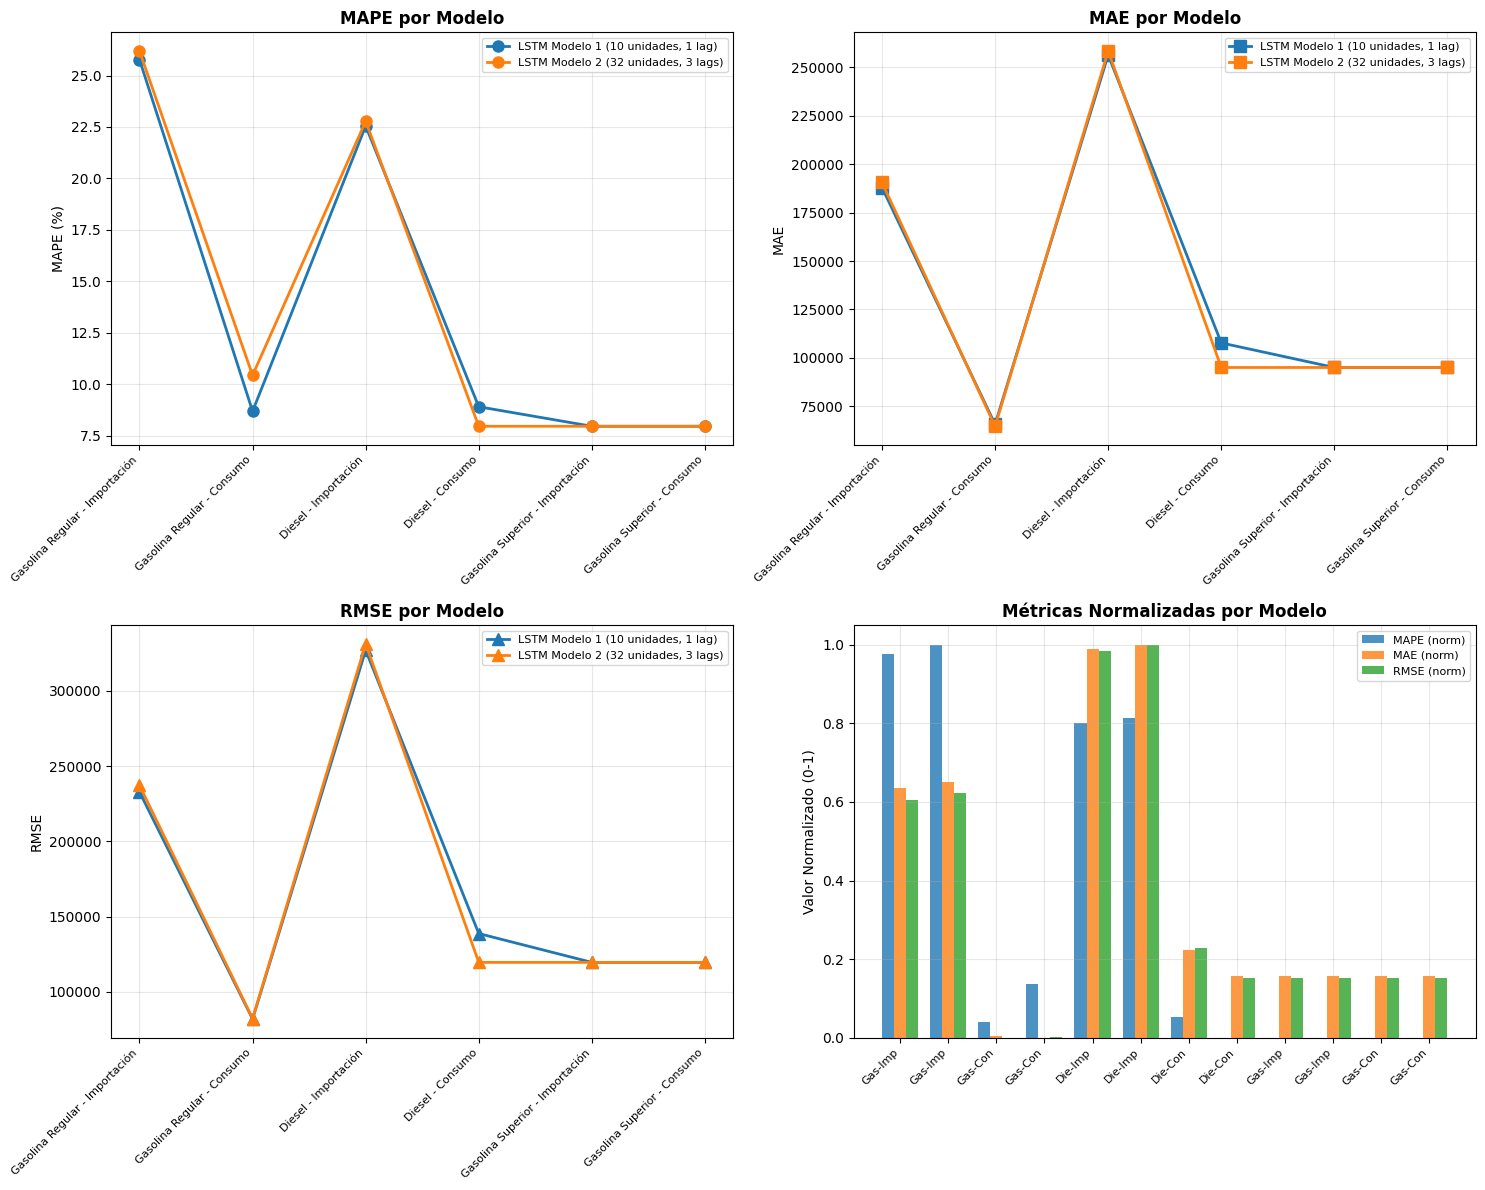

In [378]:
# Visualizaciones de las métricas
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: MAPE por Combustible y Escenario
df_plot = df_metricas.copy()
df_plot['Combustible_Escenario'] = df_plot['Combustible'] + ' - ' + df_plot['Escenario']

ax1 = axes[0, 0]
for i, modelo in enumerate(df_plot['Modelo'].unique()):
    data = df_plot[df_plot['Modelo'] == modelo]
    ax1.plot(range(len(data)), data['MAPE'], marker='o', label=modelo, linewidth=2, markersize=8)
ax1.set_title('MAPE por Modelo', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAPE (%)', fontsize=10)
ax1.set_xticks(range(len(df_plot['Combustible_Escenario'].unique())))
ax1.set_xticklabels(df_plot['Combustible_Escenario'].unique(), rotation=45, ha='right', fontsize=8)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Gráfico 2: MAE por Combustible y Escenario
ax2 = axes[0, 1]
for i, modelo in enumerate(df_plot['Modelo'].unique()):
    data = df_plot[df_plot['Modelo'] == modelo]
    ax2.plot(range(len(data)), data['MAE'], marker='s', label=modelo, linewidth=2, markersize=8)
ax2.set_title('MAE por Modelo', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=10)
ax2.set_xticks(range(len(df_plot['Combustible_Escenario'].unique())))
ax2.set_xticklabels(df_plot['Combustible_Escenario'].unique(), rotation=45, ha='right', fontsize=8)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Gráfico 3: RMSE por Combustible y Escenario
ax3 = axes[1, 0]
for i, modelo in enumerate(df_plot['Modelo'].unique()):
    data = df_plot[df_plot['Modelo'] == modelo]
    ax3.plot(range(len(data)), data['RMSE'], marker='^', label=modelo, linewidth=2, markersize=8)
ax3.set_title('RMSE por Modelo', fontsize=12, fontweight='bold')
ax3.set_ylabel('RMSE', fontsize=10)
ax3.set_xticks(range(len(df_plot['Combustible_Escenario'].unique())))
ax3.set_xticklabels(df_plot['Combustible_Escenario'].unique(), rotation=45, ha='right', fontsize=8)
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Gráfico 4: Comparación de métricas normalizadas
ax4 = axes[1, 1]
# Normalizar las métricas para comparación
df_norm = df_metricas.copy()
for metric in ['MAPE', 'MAE', 'RMSE']:
    df_norm[f'{metric}_norm'] = (df_norm[metric] - df_norm[metric].min()) / (df_norm[metric].max() - df_norm[metric].min())

x_pos = range(len(df_norm))
width = 0.25
ax4.bar([x - width for x in x_pos], df_norm['MAPE_norm'], width, label='MAPE (norm)', alpha=0.8)
ax4.bar(x_pos, df_norm['MAE_norm'], width, label='MAE (norm)', alpha=0.8)
ax4.bar([x + width for x in x_pos], df_norm['RMSE_norm'], width, label='RMSE (norm)', alpha=0.8)
ax4.set_title('Métricas Normalizadas por Modelo', fontsize=12, fontweight='bold')
ax4.set_ylabel('Valor Normalizado (0-1)', fontsize=10)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{row['Combustible'][:3]}-{row['Escenario'][:3]}" for _, row in df_norm.iterrows()], 
                    rotation=45, ha='right', fontsize=8)
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()